In [9]:
install.packages(c("readxl", "dplyr", "tidyr", "writexl", "mFilter", "plm"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [86]:
library(readxl)
library(dplyr)
library(tidyr)
library(writexl)
library(httr)
library(jsonlite)
library(plm)
library(lmtest)
library(sandwich)
library(mFilter)

In [87]:
# parse IMF API response into dataframe
parse_imf_data <- function(imf_response, indicator_name) {

  indicator_code <- names(imf_response$values)[1]
  countries_data <- imf_response$values[[indicator_code]]

  df_list <- lapply(names(countries_data), function(country) {
    years_values <- countries_data[[country]]

    data.frame(
      country = country,
      year = as.integer(names(years_values)),
      value = as.numeric(unlist(years_values)),
      stringsAsFactors = FALSE
    )
  })

  df <- do.call(rbind, df_list)
  colnames(df)[3] <- indicator_name

  return(df)
}

# download data from IMF API
get_imf_data <- function(indicator_id, country_codes, start_year = 1980, end_year = 2022) {

  base_url <- "https://www.imf.org/external/datamapper/api/v1"
  countries <- paste(country_codes, collapse = "/")
  years <- paste(start_year:end_year, collapse = ",")

  url <- paste0(base_url, "/", indicator_id, "/", countries, "?periods=", years)

  cat("downloading:", indicator_id, "\n")

  response <- GET(url)

  if (status_code(response) != 200) {
    cat("error:", status_code(response), "\n")
    return(NULL)
  }

  data <- content(response, "text", encoding = "UTF-8")
  result <- fromJSON(data, flatten = TRUE)

  return(result)
}

In [88]:
# download data
countries <- c("AUS", "AUT", "BEL", "CAN", "DNK", "FIN", "FRA", "DEU",
             "GRC", "ISL", "IRL", "ISR", "ITA", "JPN", "KOR", "NLD",
             "NZL", "NOR", "PRT", "ESP", "SWE", "GBR", "USA")

#

start_year<-1980
end_year <- 2024

# download data
debt_df <- parse_imf_data(get_imf_data("GGXWDG_NGDP", countries, start_year, end_year), "debt_to_gdp")
pb_df <- parse_imf_data(get_imf_data("pb", countries, start_year, end_year), "primary_balance")
interest_df <- parse_imf_data(get_imf_data("ie", countries, start_year, end_year), "interest_pct_gdp")
real_growth_df <- parse_imf_data(get_imf_data("rgc", countries, start_year, end_year), "r_gdp_growth")
inflation_df <- parse_imf_data(get_imf_data("PCPIPCH", countries, start_year, end_year), "inflation")
exp_df <- parse_imf_data(get_imf_data("prim_exp", countries, start_year, end_year), "govt_expenditure")

# calculate nominal interest rate (r) from interest payments
# assumption: r ≈ (interest / lagged_debt) × 100
# note: simplified version ignoring nominal gdp growth adjustment
calculate_r_nominal <- function(interest_pct_gdp, lagged_debt) {
  r_nominal <- (interest_pct_gdp / lagged_debt) * 100
  return(r_nominal)
}

# calculate nominal gdp growth (g) from real growth and inflation
# fisher equation approximation: n_gdp_growth ≈ r_gdp_growth + inflation
calculate_n_gdp_growth <- function(r_gdp_growth, inflation) {
  n_gdp_growth <- r_gdp_growth + inflation
  return(n_gdp_growth)
}

# merge and create variables
fiscal_data <- debt_df %>%
  left_join(pb_df, by = c("country", "year")) %>%
  left_join(interest_df, by = c("country", "year")) %>%
  left_join(real_growth_df, by = c("country", "year")) %>%
  left_join(inflation_df, by = c("country", "year")) %>%
  left_join(exp_df, by = c("country", "year")) %>%
  arrange(country, year) %>%
  group_by(country) %>%
  mutate(
    lagged_debt = dplyr::lag(debt_to_gdp, n = 1),
    lagged_debt_sq = lagged_debt^2,
    lagged_debt_cubic = lagged_debt^3,

    # calculate r and nominal gdp growth
    r_nominal = calculate_r_nominal(interest_pct_gdp, lagged_debt),
    n_gdp_growth = calculate_n_gdp_growth(r_gdp_growth, inflation),

    # HP filter pour govt_expenditure trend
    govt_exp_trend = if(sum(!is.na(govt_expenditure)) >= 10) {
      hp_result <- hpfilter(govt_expenditure[!is.na(govt_expenditure)], freq = 100)
      hp_trend <- rep(NA, length(govt_expenditure))
      hp_trend[!is.na(govt_expenditure)] <- hp_result$trend
      hp_trend
    } else {
      NA_real_
    },
    govt_exp_gap = govt_expenditure - govt_exp_trend,

    # HP filter pour r_gdp_growth (output gap)
    gdp_trend = if(sum(!is.na(r_gdp_growth)) >= 10) {
      hp_result <- hpfilter(r_gdp_growth[!is.na(r_gdp_growth)], freq = 100)
      hp_trend <- rep(NA, length(r_gdp_growth))
      hp_trend[!is.na(r_gdp_growth)] <- hp_result$trend
      hp_trend
    } else {
      NA_real_
    },
    output_gap = r_gdp_growth - gdp_trend
  ) %>%
  ungroup()

fiscal_data <- fiscal_data %>%
  filter(
    !is.na(debt_to_gdp) &
    !is.na(primary_balance) &
    !is.na(r_gdp_growth) &
    !is.na(govt_expenditure) &
    !is.na(lagged_debt) &
    !is.na(output_gap) &
    !is.na(govt_exp_gap) &
    !is.na(r_nominal) &
    !is.na(n_gdp_growth)
  )

downloading: GGXWDG_NGDP 
downloading: pb 
downloading: ie 
downloading: rgc 
downloading: PCPIPCH 
downloading: prim_exp 


In [89]:
fiscal_data

country,year,debt_to_gdp,primary_balance,interest_pct_gdp,r_gdp_growth,inflation,govt_expenditure,lagged_debt,lagged_debt_sq,lagged_debt_cubic,r_nominal,n_gdp_growth,govt_exp_trend,govt_exp_gap,gdp_trend,output_gap
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AUS,1990,16.4,1.14152622,4.300454,1.5078538,7.2,31.79814,17.0,289.00,4913.000,25.296789,8.707854,32.34980,-0.55165739,2.501877,-0.99402316
AUS,1991,21.6,-1.84710026,4.074725,-0.9991462,3.3,34.01856,16.4,268.96,4410.944,24.845885,2.300854,32.58993,1.42862844,2.682973,-3.68211876
AUS,1992,27.6,-2.68826604,3.665799,2.5925215,1.0,34.37333,21.6,466.56,10077.696,16.971291,3.592522,32.77981,1.59351945,2.900113,-0.30759138
AUS,1993,30.7,-0.69434452,3.962207,3.9310285,1.8,33.98497,27.6,761.76,21024.576,14.355822,5.731029,32.90587,1.07910059,3.129529,0.80149928
AUS,1994,31.7,-0.19438934,4.171837,4.8497971,1.9,33.57331,30.7,942.49,28934.443,13.589045,6.749797,32.97043,0.60288272,3.344377,1.50542040
AUS,1995,31.1,0.83518219,4.010723,2.9554325,4.6,32.86603,31.7,1004.89,31855.013,12.652123,7.555432,32.98664,-0.12061517,3.525825,-0.57039300
AUS,1996,29.3,1.83453178,3.331347,4.0238333,2.7,32.71973,31.1,967.21,30080.231,10.711725,6.723833,32.97366,-0.25393442,3.670100,0.35373331
AUS,1997,25.9,2.59185934,2.720987,4.6239170,0.2,32.08189,29.3,858.49,25153.757,9.286645,4.823917,32.94945,-0.86755990,3.767721,0.85619627
AUS,1998,23.7,2.72201633,2.347295,4.6497204,0.9,32.64942,25.9,670.81,17373.979,9.062914,5.549720,32.92942,-0.27999310,3.812746,0.83697487


In [90]:
# POOLED regression with country fixed effects (Ghosh approach)
model1 <- plm(primary_balance ~ lagged_debt + lagged_debt_sq + lagged_debt_cubic + output_gap +govt_exp_gap,
              data = fiscal_data,
              index = c("country", "year"),
              model = "within",
              effect = "individual")

summary(model1)


# extract fixed effects (μ - different per country)
fixed_fx <- fixef(model1)
print("\nCountry-specific intercepts (μ):")
print(fixed_fx)


##with predicted AR(1) error
model_ar1<- pggls(primary_balance ~ lagged_debt + lagged_debt_sq + lagged_debt_cubic + output_gap + govt_exp_gap,
              data = fiscal_data,
              index = c("country", "year"),
              model = "within",
              effect = "individual")

summary(model_ar1)


Oneway (individual) effect Within Model

Call:
plm(formula = primary_balance ~ lagged_debt + lagged_debt_sq + 
    lagged_debt_cubic + output_gap + govt_exp_gap, data = fiscal_data, 
    effect = "individual", model = "within", index = c("country", 
        "year"))

Unbalanced Panel: n = 23, T = 22-43, N = 845

Residuals:
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-6.53767 -1.71948 -0.10179  1.44478 15.04435 

Coefficients:
                     Estimate  Std. Error  t-value Pr(>|t|)    
lagged_debt       -2.7664e-02  1.9793e-02  -1.3976   0.1626    
lagged_debt_sq     2.1488e-04  1.9569e-04   1.0981   0.2725    
lagged_debt_cubic -6.7220e-07  5.4646e-07  -1.2301   0.2190    
output_gap         4.1496e-02  3.7651e-02   1.1021   0.2707    
govt_exp_gap      -1.0531e+00  4.1290e-02 -25.5058   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    9598
Residual Sum of Squares: 4783.1
R-Squared:      0.50166
Adj. R-Squared: 0.48519
F-stat

[1] "\nCountry-specific intercepts (μ):"
     AUS      AUT      BEL      CAN      DEU      DNK      ESP      FIN 
 0.37746  1.28865  2.88449  4.24552  1.58035  4.09947 -0.46101  2.95633 
     FRA      GBR      GRC      IRL      ISL      ISR      ITA      JPN 
-0.27395 -0.11994 -0.18414  0.36812  5.06276  1.53023  2.65109  0.40237 
     KOR      NLD      NOR      NZL      PRT      SWE      USA 
 2.71703  2.00269 10.70985  3.51780  0.81395  2.33037 -2.27944 


Oneway (individual) effect Within FGLS model

Call:
pggls(formula = primary_balance ~ lagged_debt + lagged_debt_sq + 
    lagged_debt_cubic + output_gap + govt_exp_gap, data = fiscal_data, 
    effect = "individual", model = "within", index = c("country", 
        "year"))

Unbalanced Panel: n = 23, T = 22-43, N = 845

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-7.58821237 -1.67433263 -0.07912437  1.51309492 15.82447439 

Coefficients:
                     Estimate  Std. Error   z-value  Pr(>|z|)    
lagged_debt       -3.1313e-02  2.2098e-03  -14.1703 < 2.2e-16 ***
lagged_debt_sq    -8.4622e-05  2.3561e-05   -3.5916 0.0003287 ***
lagged_debt_cubic  3.2659e-07  7.6521e-08    4.2680 1.972e-05 ***
output_gap         5.6226e-02  1.3820e-03   40.6838 < 2.2e-16 ***
govt_exp_gap      -1.0679e+00  1.9188e-03 -556.5173 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Total Sum of Squares: 15929
Residual Sum of Squares: 5201.9
Multiple

In [91]:
# POOLED regression with country fixed effects (Ghosh approach without gvt exp gap)
model2 <- plm(primary_balance ~ lagged_debt + lagged_debt_sq + lagged_debt_cubic + output_gap ,
              data = fiscal_data,
              index = c("country", "year"),
              model = "within",
              effect = "individual")

summary(model2)


# extract fixed effects (μ - different per country)
fixed_fx <- fixef(model2)
print("\nCountry-specific intercepts (μ):")
print(fixed_fx)


# Durbin-Watson test for AR(1)
dw_test <- pdwtest(model2)
cat("\nDurbin-Watson Test for Autocorrelation:\n")
print(dw_test)
cat("DW statistic close to 2 = no autocorrelation\n")
cat("p-value < 0.05 = significant autocorrelation detected\n\n")

##with predicted AR(1) error
model_ar2<- pggls(primary_balance ~ lagged_debt + lagged_debt_sq + lagged_debt_cubic + output_gap ,
              data = fiscal_data,
              index = c("country", "year"),
              model = "within",
              effect = "individual")

summary(model_ar2)





# with more AR structure (and remove square term because non significative)
model_ar2_lag2 <- pggls(primary_balance ~ lagged_debt + lagged_debt_cubic + output_gap + lag(primary_balance, 1),
                        data = fiscal_data,
                        index = c("country", "year"),
                        model = "within")

summary(model_ar2_lag2)



Oneway (individual) effect Within Model

Call:
plm(formula = primary_balance ~ lagged_debt + lagged_debt_sq + 
    lagged_debt_cubic + output_gap, data = fiscal_data, effect = "individual", 
    model = "within", index = c("country", "year"))

Unbalanced Panel: n = 23, T = 22-43, N = 845

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-26.967206  -1.739606   0.071007   1.931311  15.493832 

Coefficients:
                     Estimate  Std. Error t-value  Pr(>|t|)    
lagged_debt       -7.2350e-02  2.6408e-02 -2.7397  0.006283 ** 
lagged_debt_sq     6.4535e-04  2.6114e-04  2.4713  0.013665 *  
lagged_debt_cubic -1.8320e-06  7.2941e-07 -2.5116  0.012212 *  
output_gap         4.2795e-01  4.6167e-02  9.2696 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    9598
Residual Sum of Squares: 8591.7
R-Squared:      0.10484
Adj. R-Squared: 0.076393
F-statistic: 23.952 on 4 and 818 DF, p-value: < 2.22e-16

[1] "\nCountry-specific intercepts (μ):"
     AUS      AUT      BEL      CAN      DEU      DNK      ESP      FIN 
 1.19641  2.68815  4.06346  5.58470  2.94111  5.29063  0.72956  4.07242 
     FRA      GBR      GRC      IRL      ISL      ISR      ITA      JPN 
 0.93801  1.02514  0.92234  1.69287  6.33258  2.88054  3.82140  1.81967 
     KOR      NLD      NOR      NZL      PRT      SWE      USA 
 3.54951  3.34210 11.87209  4.56280  2.08323  3.64690 -1.01080 

Durbin-Watson Test for Autocorrelation:

	Durbin-Watson test for serial correlation in panel models

data:  primary_balance ~ lagged_debt + lagged_debt_sq + lagged_debt_cubic +  ...
DW = 0.69025, p-value < 2.2e-16
alternative hypothesis: serial correlation in idiosyncratic errors

DW statistic close to 2 = no autocorrelation
p-value < 0.05 = significant autocorrelation detected



Oneway (individual) effect Within FGLS model

Call:
pggls(formula = primary_balance ~ lagged_debt + lagged_debt_sq + 
    lagged_debt_cubic + output_gap, data = fiscal_data, effect = "individual", 
    model = "within", index = c("country", "year"))

Unbalanced Panel: n = 23, T = 22-43, N = 845

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-27.1196199  -1.8362603   0.1274901   1.9824439  15.5137674 

Coefficients:
                     Estimate  Std. Error  z-value  Pr(>|z|)    
lagged_debt       -5.3144e-02  5.0252e-03 -10.5754 < 2.2e-16 ***
lagged_debt_sq     5.4374e-04  5.8201e-05   9.3424 < 2.2e-16 ***
lagged_debt_cubic -1.8818e-06  1.9401e-07  -9.6999 < 2.2e-16 ***
output_gap         3.8119e-01  3.3539e-03 113.6543 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Total Sum of Squares: 15929
Residual Sum of Squares: 8678.1
Multiple R-squared: 0.45521

Oneway (individual) effect Within FGLS model

Call:
pggls(formula = primary_balance ~ lagged_debt + lagged_debt_cubic + 
    output_gap + lag(primary_balance, 1), data = fiscal_data, 
    model = "within", index = c("country", "year"))

Unbalanced Panel: n = 23, T = 21-42, N = 822

Residuals:
        Min.      1st Qu.       Median      3rd Qu.         Max. 
-18.94951264  -0.89575131   0.09905938   1.03457970  14.40102341 

Coefficients:
                           Estimate  Std. Error z-value  Pr(>|z|)    
lagged_debt              2.6082e-02  6.5542e-04  39.794 < 2.2e-16 ***
lagged_debt_cubic       -3.2753e-07  1.1273e-08 -29.055 < 2.2e-16 ***
output_gap               5.3451e-01  3.3648e-03 158.853 < 2.2e-16 ***
lag(primary_balance, 1)  6.9771e-01  2.6290e-03 265.388 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Total Sum of Squares: 15661
Residual Sum of Squares: 3802.8
Multiple R-squared: 0.75718

In [102]:
### autocorrelation tests

residuals2 <- residuals(model2)
box_test <- Box.test(residuals2, lag = 1, type = "Ljung-Box")
print(box_test)

residuals_ar2 <- residuals(model_ar2)
box_test <- Box.test(residuals_ar2, lag = 1, type = "Ljung-Box")
print(box_test)

residuals_ar2_lag2 <- residuals(model_ar2_lag2)
box_test <- Box.test(residuals_ar2_lag2, lag = 1, type = "Ljung-Box")
print(box_test)



	Box-Ljung test

data:  residuals2
X-squared = 363.54, df = 1, p-value < 2.2e-16


	Box-Ljung test

data:  residuals_ar2
X-squared = 374.7, df = 1, p-value < 2.2e-16


	Box-Ljung test

data:  residuals_ar2_lag2
X-squared = 3.1124, df = 1, p-value = 0.0777



In [93]:
#"We use the pggls AR(1) (or named model_ar2 here) specification without lagged dependent variable to maintain consistency with Ghosh et al.
#While this specification exhibits residual autocorrelation and the coefficients lose significance under robust standard errors,
#our primary objective is to replicate their fiscal reaction function framework rather than achieve optimal econometric properties.
#The debt limit calculations (d̄) therefore follow their original approach, acknowledging this  choice prioritizes replication over statistical refinement.

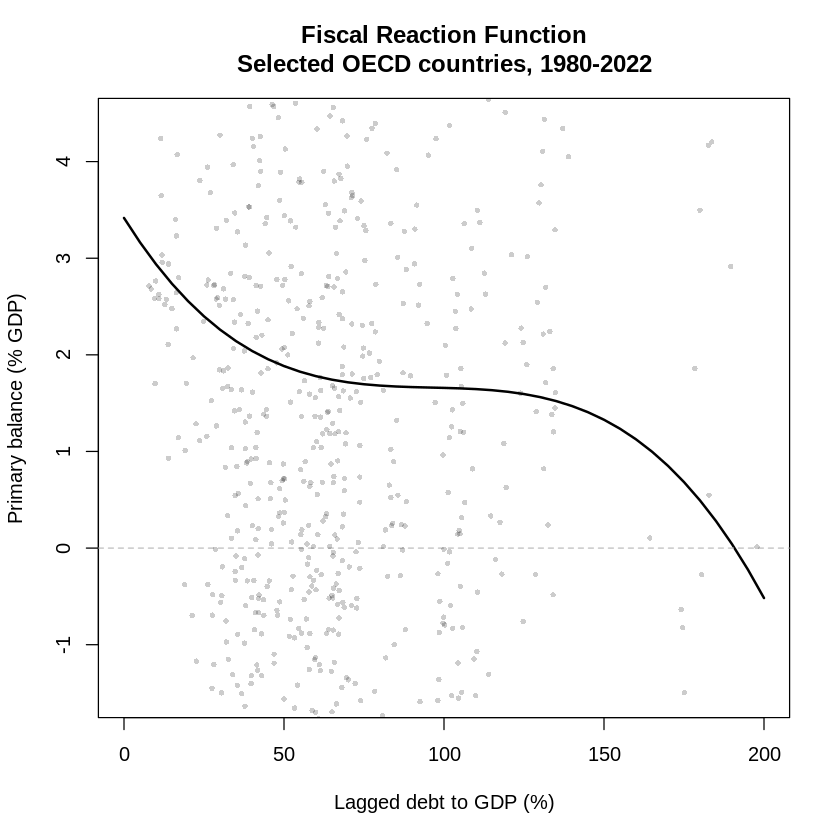

In [94]:
###with model AR(1)
#graphic visualization of fiscal reaction function
# get coefficients
b1 <- coef(model_ar2)["lagged_debt"]
b2 <- coef(model_ar2)["lagged_debt_sq"]
b3 <- coef(model_ar2)["lagged_debt_cubic"]

# get mean of fixed effects
mean_fx <- mean(fixef(model_ar1))

# predict with fixed effects added
debt_range <- seq(0, 200, by = 5)
predicted_pb <- mean_fx + b1 * debt_range + b2 * debt_range^2 + b3 * debt_range^3

# plot
plot(debt_range, predicted_pb,
     type = "l",
     lwd = 2,
     xlab = "Lagged debt to GDP (%)",
     ylab = "Primary balance (% GDP)",
     main = "Fiscal Reaction Function\nSelected OECD countries, 1980-2022",
     ylim = c(min(predicted_pb)-1, max(predicted_pb)+1))

abline(h = 0, lty = 2, col = "gray")

# add actual data
points(fiscal_data$lagged_debt,
       fiscal_data$primary_balance,
       pch = 16, col = rgb(0, 0, 0, 0.2), cex = 0.6)

In [95]:
# calculate r-g differential with 10-year rolling average (Ghosh et al. 2013 methodology)
# uses historical 10-year average of r and g, ending at specified year
# you can adjust a x-year avg by changing the window = x
calculate_rg_differential <- function(fiscal_data, end_year, window = 10) {

  rg_data <- fiscal_data %>%
    group_by(country) %>%
    arrange(year) %>%
    mutate(
      # 10-year rolling average of r (right-aligned: uses past 10 years)
      r_10y = rollapply(r_nominal, width = window, FUN = mean,
                        align = "right", fill = NA, na.rm = TRUE),

      # 10-year rolling average of g
      g_10y = rollapply(n_gdp_growth, width = window, FUN = mean,
                        align = "right", fill = NA, na.rm = TRUE),

      # r-g differential
      rg_diff_10y = r_10y - g_10y
    ) %>%
    ungroup() %>%
    filter(year <= end_year)

  return(rg_data)
}

# compute r-g differential
rg_data <- calculate_rg_differential(fiscal_data, end_year = end_year, window = 10)

# summary by country (using most recent 10y average for each country)
rg_summary <- rg_data %>%
  filter(!is.na(rg_diff_10y)) %>%
  group_by(country) %>%
  filter(year == max(year)) %>%
  select(country, year, r_10y, g_10y, rg_diff_10y) %>%
  arrange(rg_diff_10y)

rg_summary

country,year,r_10y,g_10y,rg_diff_10y
<chr>,<int>,<dbl>,<dbl>,<dbl>
IRL,2023,2.1760256,10.151172,-7.9751468
SWE,2023,1.1807082,4.555598,-3.3748895
NLD,2023,1.5936988,4.678226,-3.0845272
NOR,2023,1.8556688,4.640243,-2.7845739
USA,2023,2.4755537,5.198859,-2.7233050
KOR,2023,1.8795922,4.477403,-2.5978104
DEU,2023,1.4212478,3.681344,-2.2600960
AUT,2023,2.0142386,4.101794,-2.0875557
DNK,2023,1.9663066,3.991773,-2.0254660


In [96]:
# find crossings
find_crossings_simple <- function(country_code, model, fixed_effects, rg_diff, max_debt = 500) {

  # coefficients
  b1 <- coef(model)["lagged_debt"]
  b2 <- coef(model)["lagged_debt_sq"]
  b3 <- coef(model)["lagged_debt_cubic"]
  mu <- fixed_effects[country_code]

  # r-g en decimal
  rg_decimal <- rg_diff / 100

  # debt range
  debt <- seq(0, max_debt, by = 0.25)

  # deux lignes
  reaction <- mu + b1*debt + b2*debt^2 + b3*debt^3
  interest <- rg_decimal * debt

  # difference
  diff <- reaction - interest

  # detect sign changes by multiplying consecutive elements (negative product = crossing)
  sign_change <- which(diff[-1] * diff[-length(diff)] < 0)

  crossings <- debt[sign_change]


  return(crossings)
}


IRL , max crossing and potential deterministic debt limit d_bar: 338.5

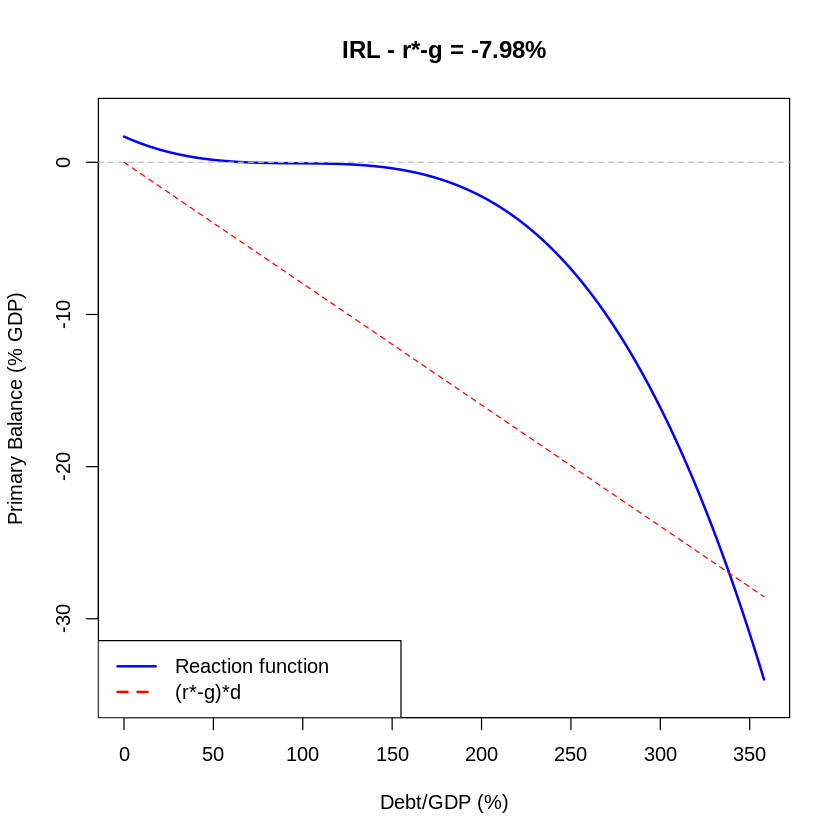

SWE , max crossing and potential deterministic debt limit d_bar: 276.75

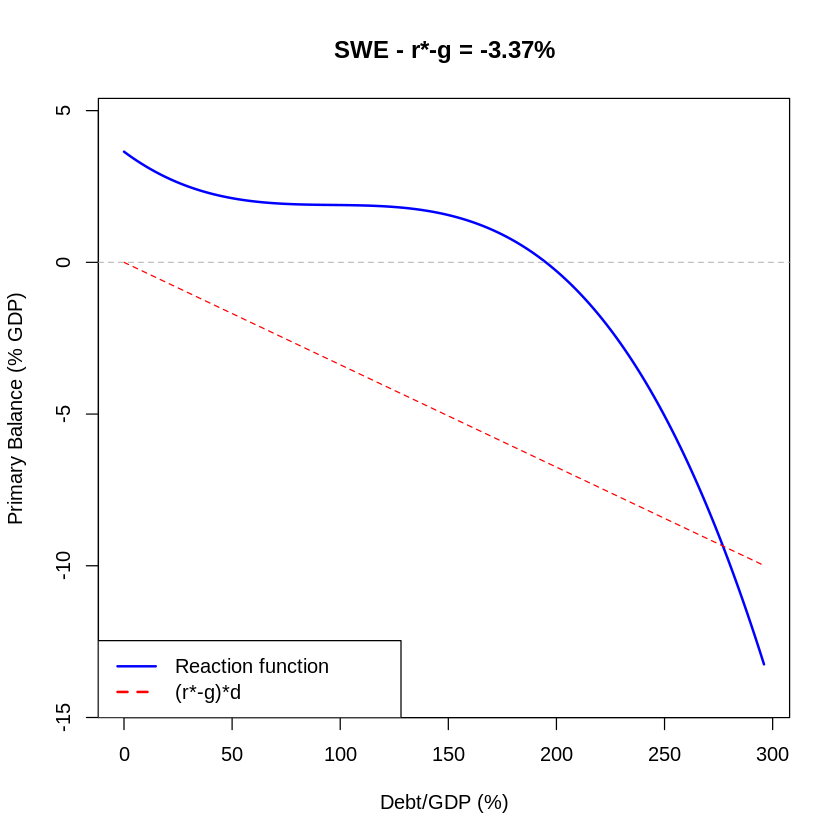

NLD , max crossing and potential deterministic debt limit d_bar: 269.25

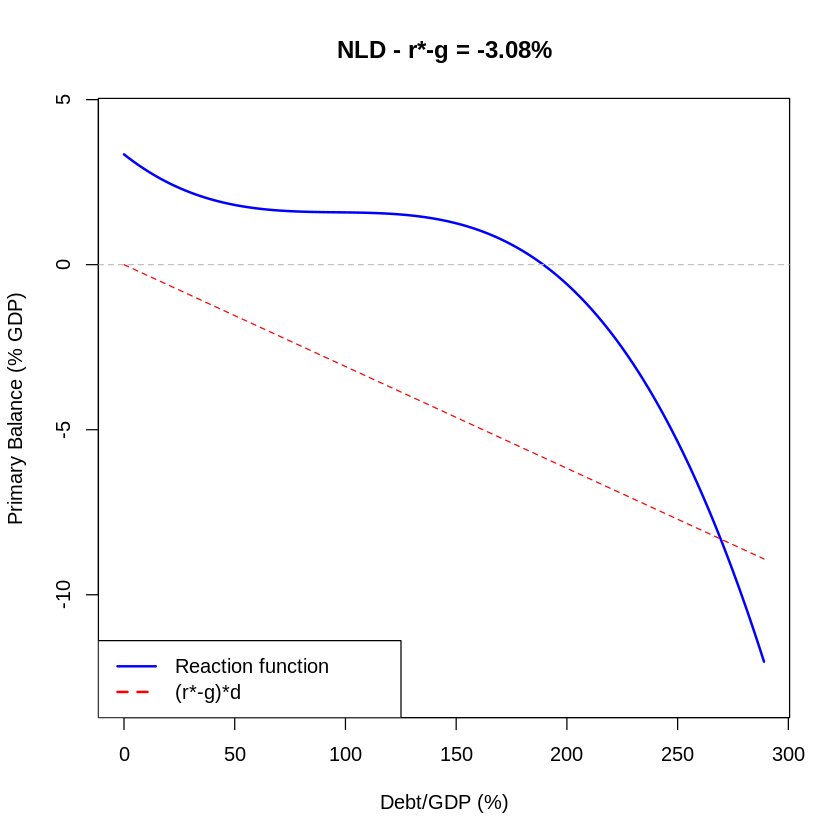

NOR , max crossing and potential deterministic debt limit d_bar: 310.75

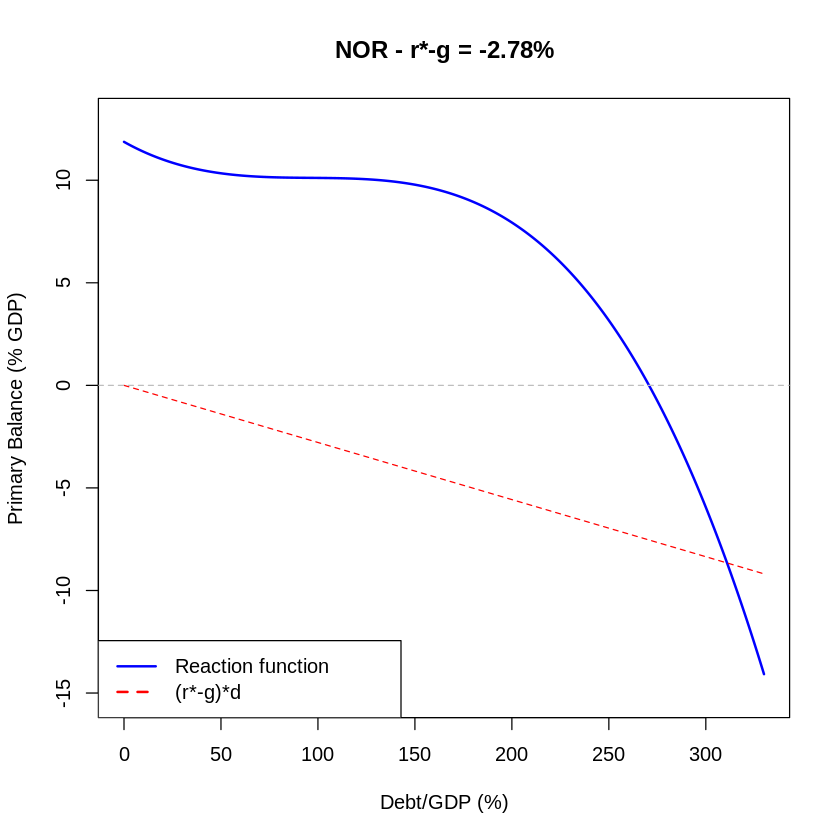

USA , max crossing and potential deterministic debt limit d_bar: 212

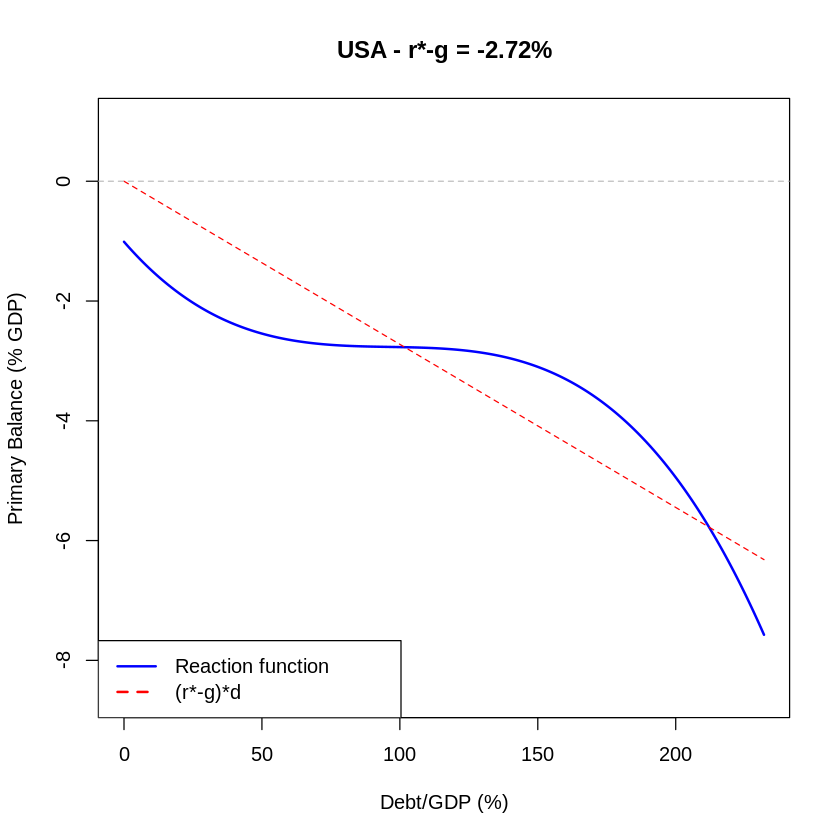

KOR , max crossing and potential deterministic debt limit d_bar: 261.25

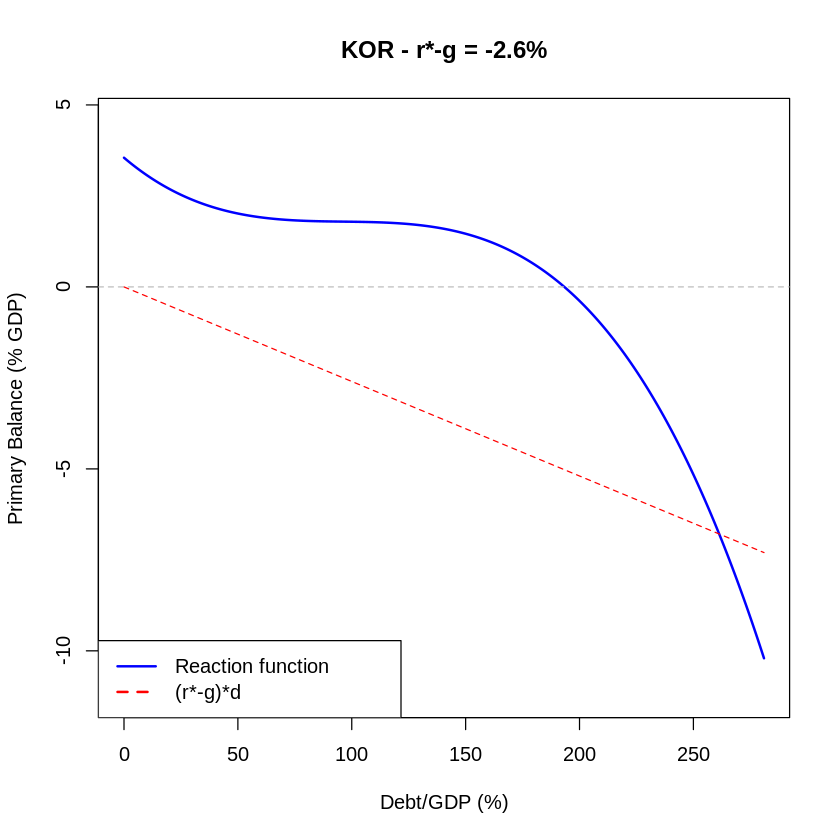

DEU , max crossing and potential deterministic debt limit d_bar: 248.75

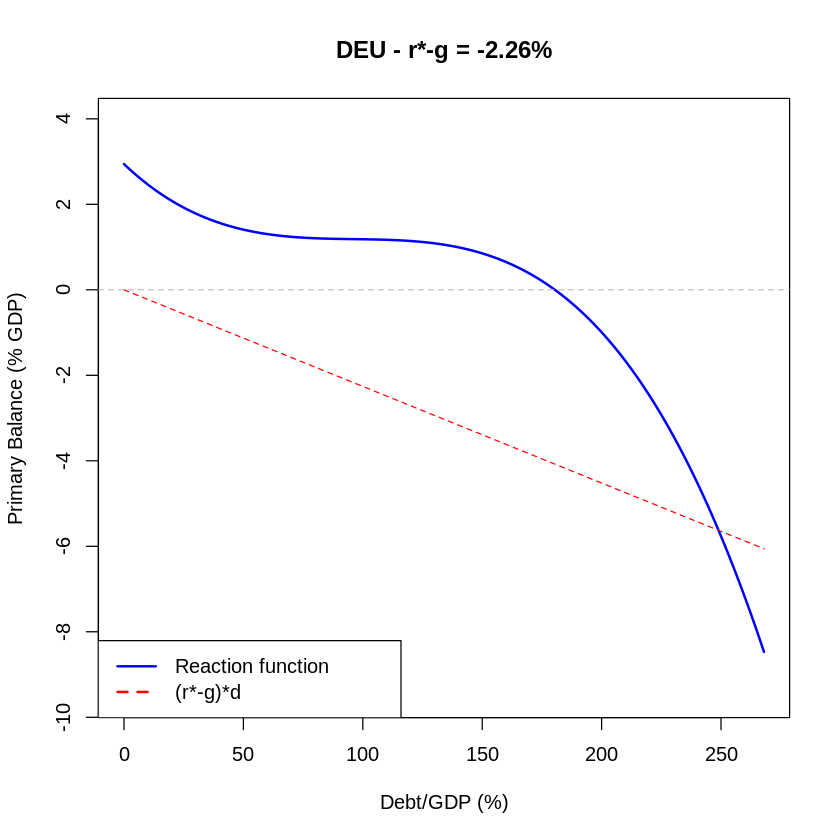

AUT , max crossing and potential deterministic debt limit d_bar: 242.5

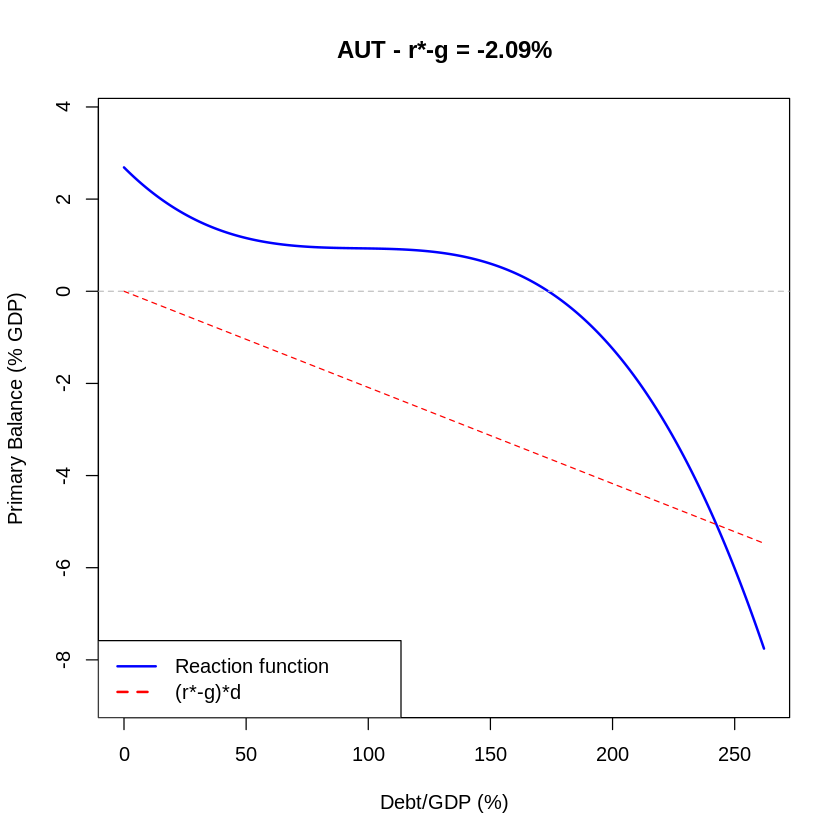

DNK , max crossing and potential deterministic debt limit d_bar: 263

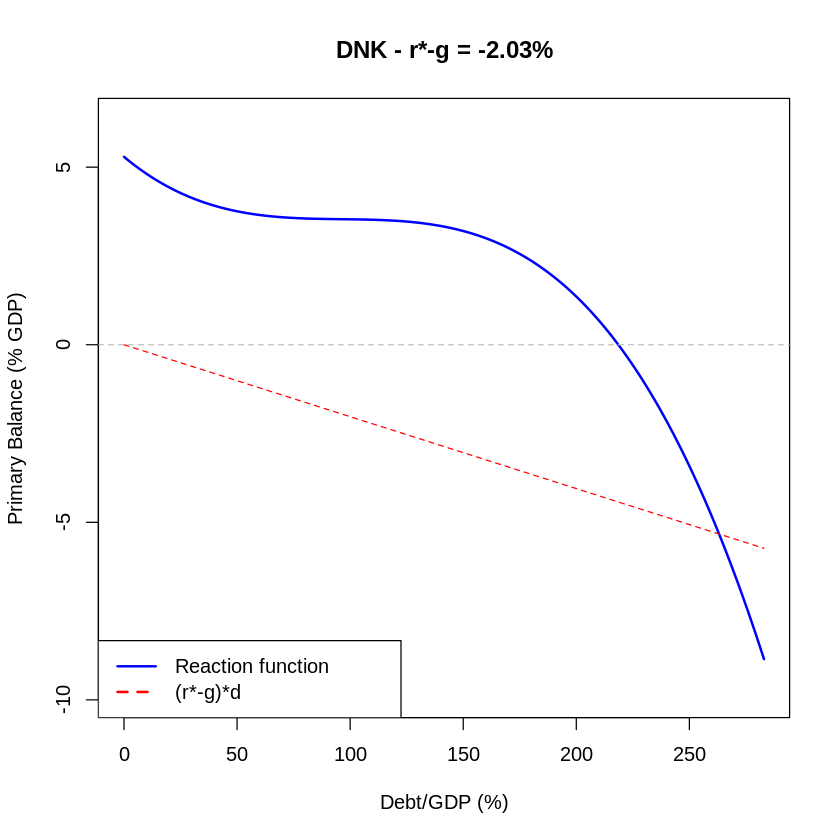

BEL , max crossing and potential deterministic debt limit d_bar: 252.75

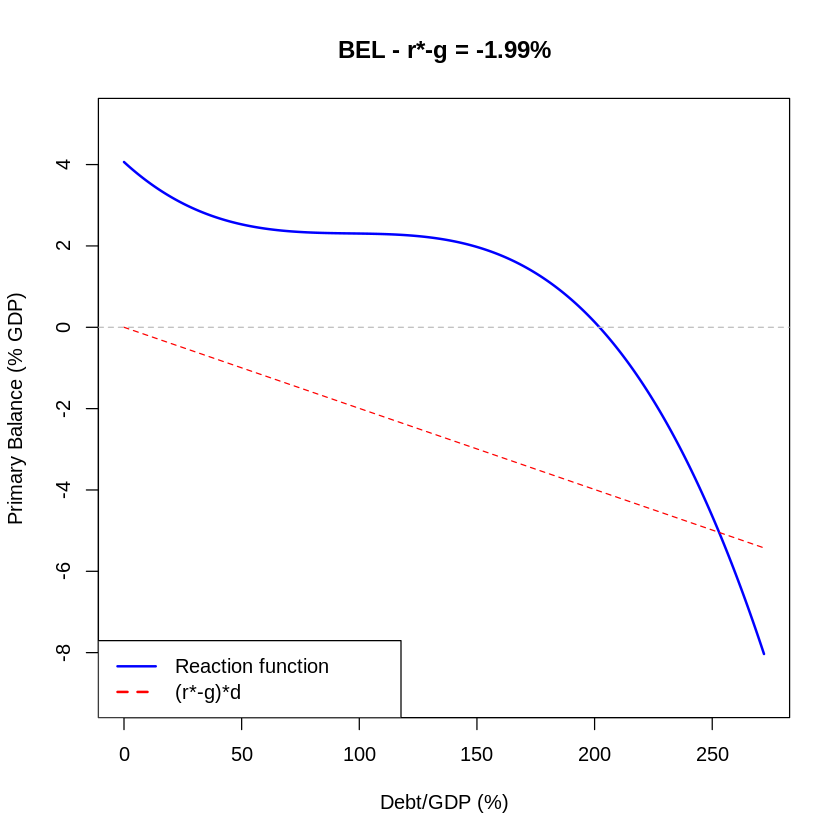

AUS , max crossing and potential deterministic debt limit d_bar: 215.25

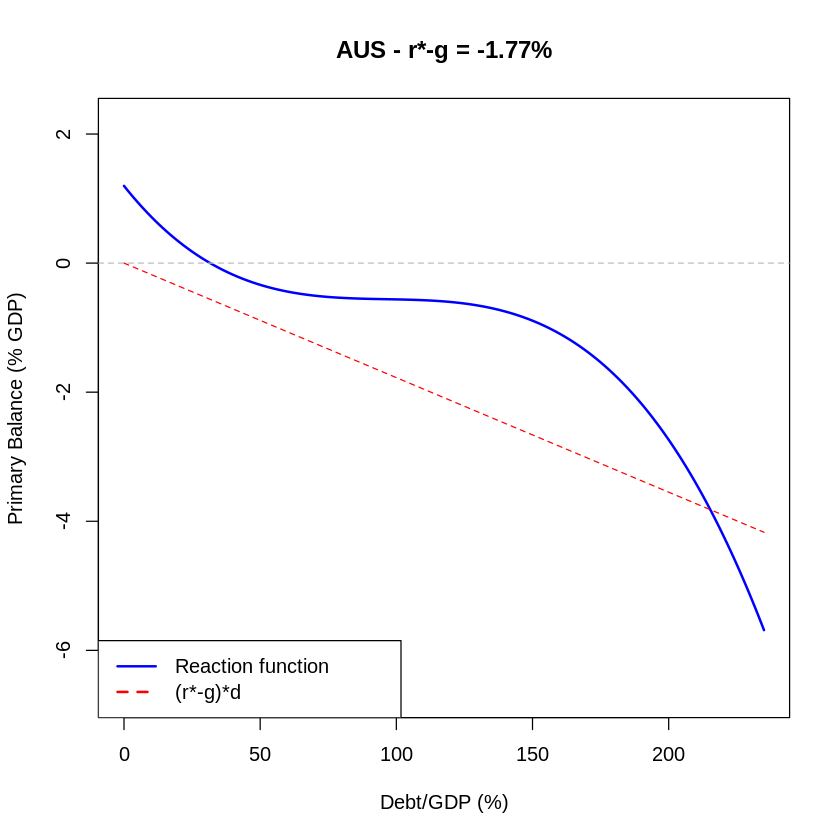

GBR , max crossing and potential deterministic debt limit d_bar: 206.25

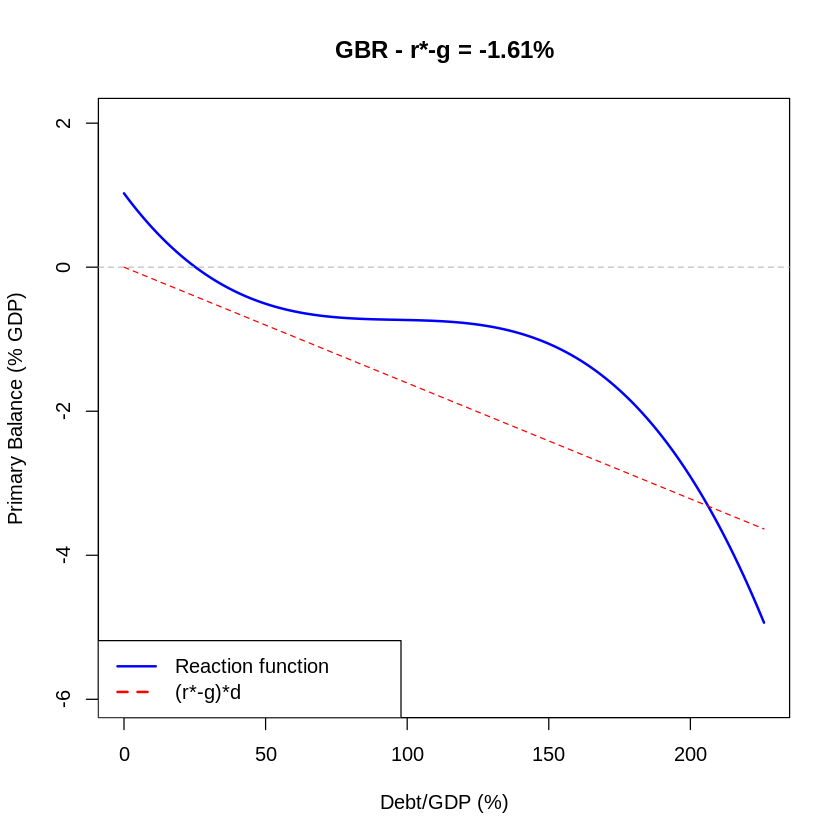

FRA , max crossing and potential deterministic debt limit d_bar: 195.5

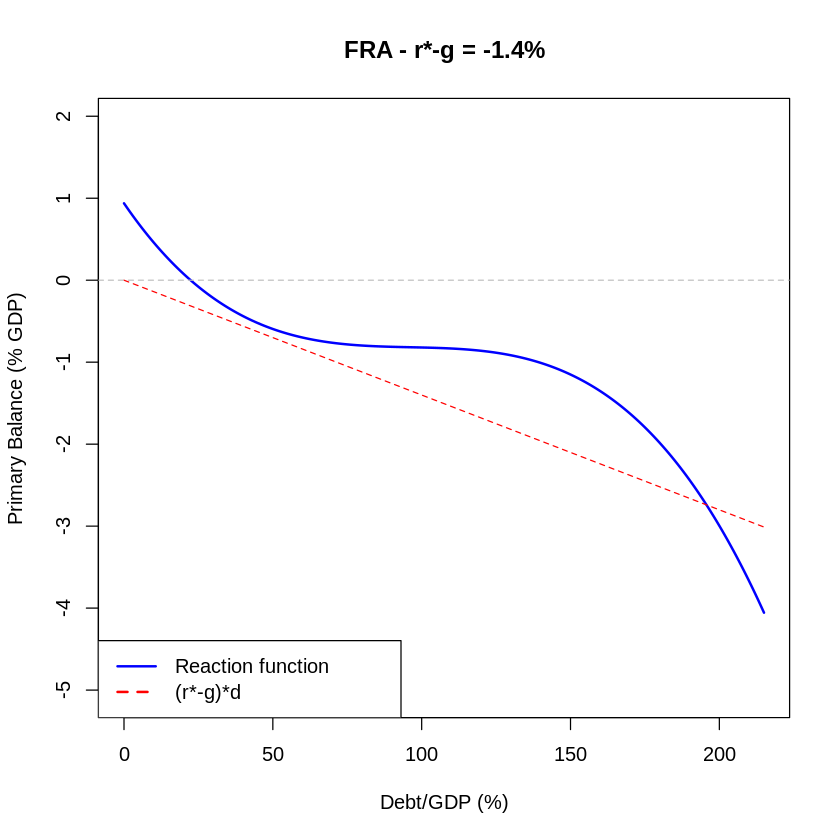

ESP , max crossing and potential deterministic debt limit d_bar: 188.75

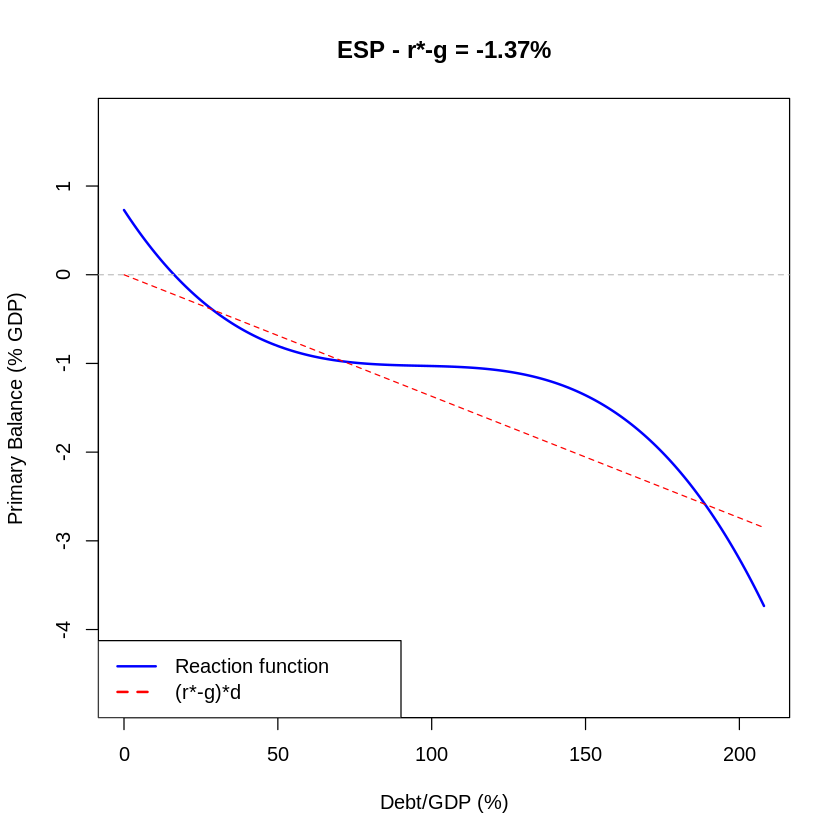

FIN , max crossing and potential deterministic debt limit d_bar: 239

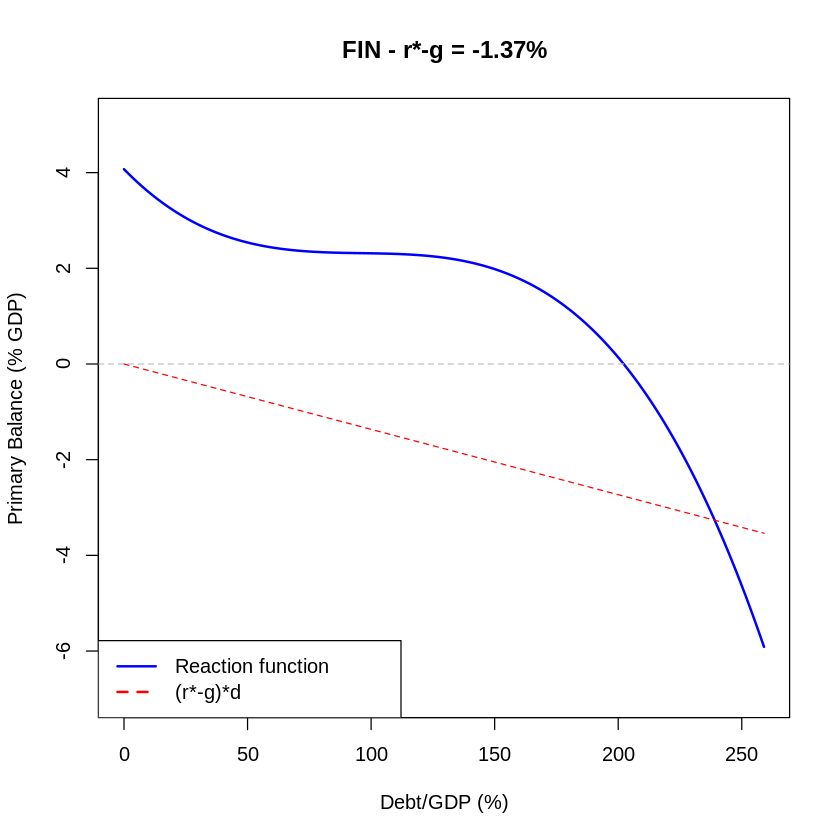

PRT , max crossing and potential deterministic debt limit d_bar: 210.75

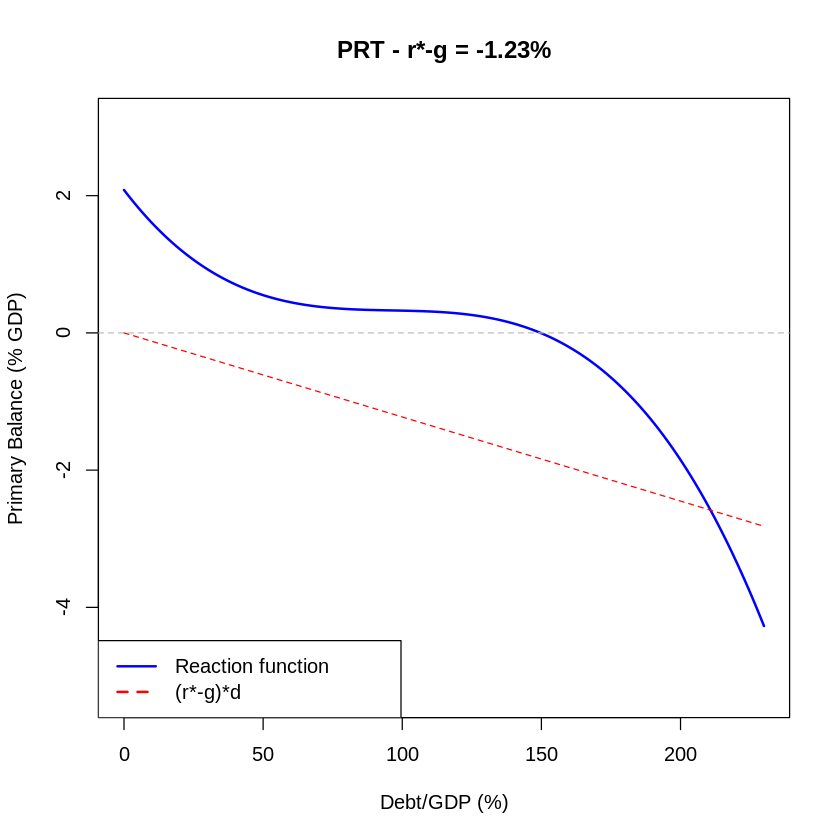

CAN , max crossing and potential deterministic debt limit d_bar: 248.25

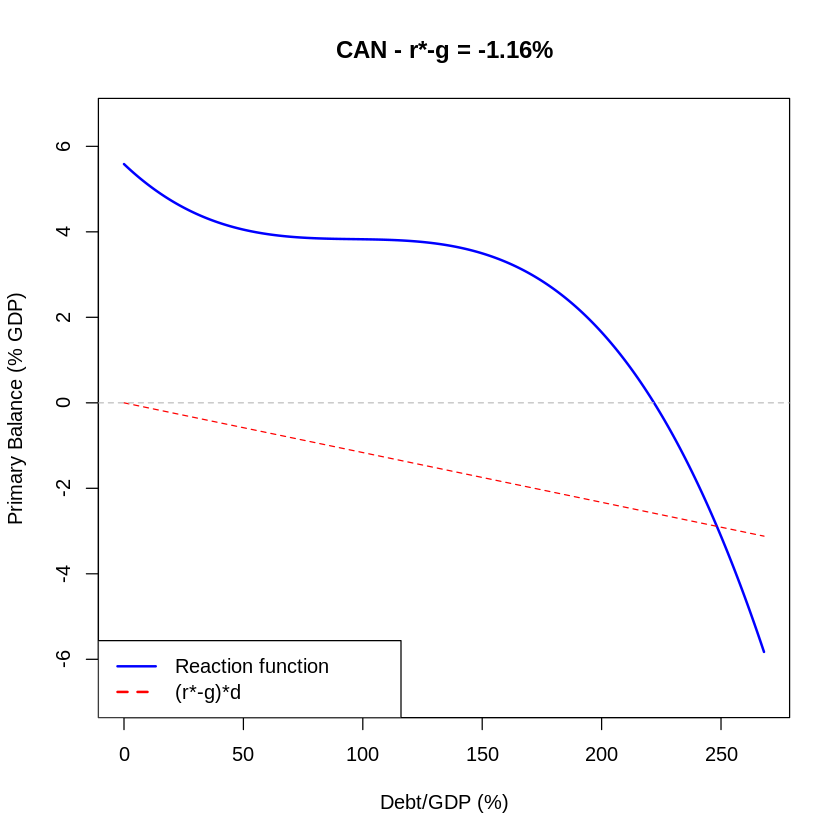

ISR , max crossing and potential deterministic debt limit d_bar: 219.25

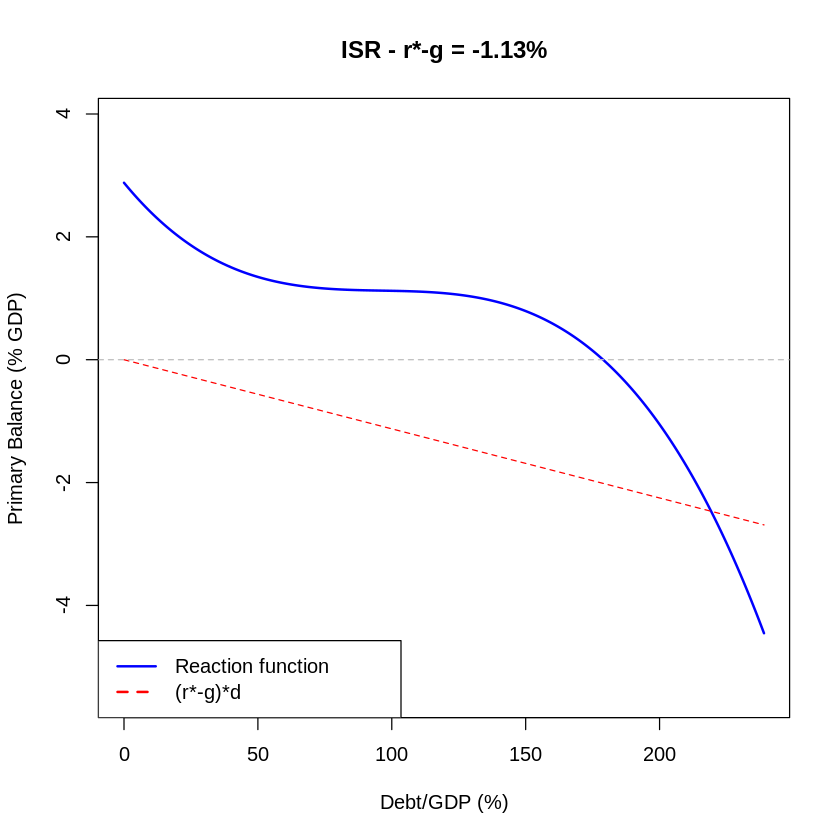

NZL , max crossing and potential deterministic debt limit d_bar: 238

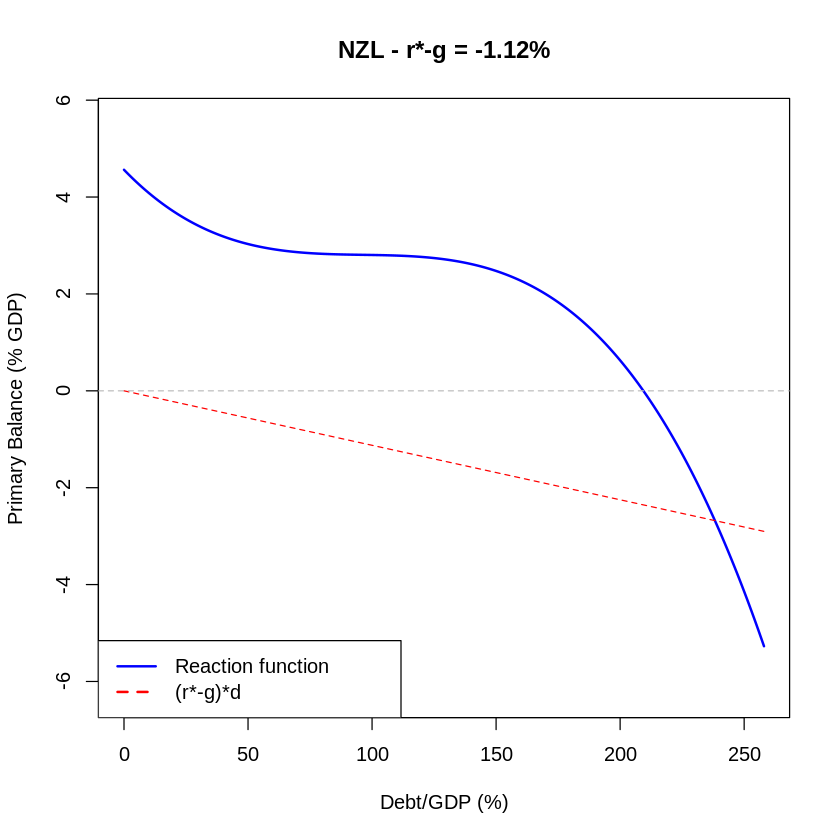

JPN , max crossing and potential deterministic debt limit d_bar: 196.5

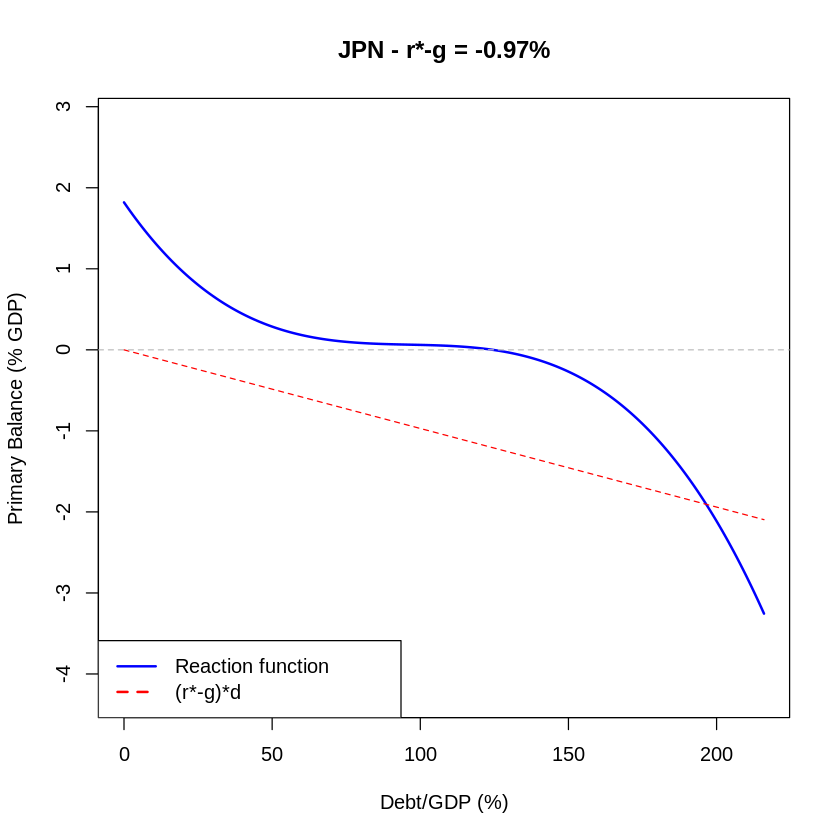

ISL , max crossing and potential deterministic debt limit d_bar: 246

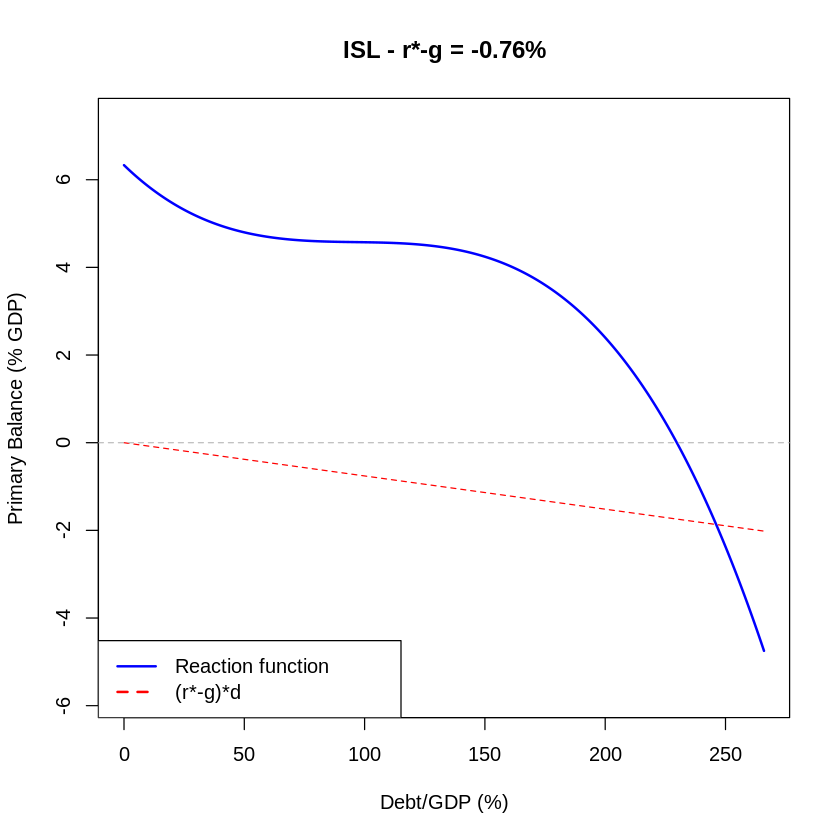

GRC , max crossing and potential deterministic debt limit d_bar: 28.75

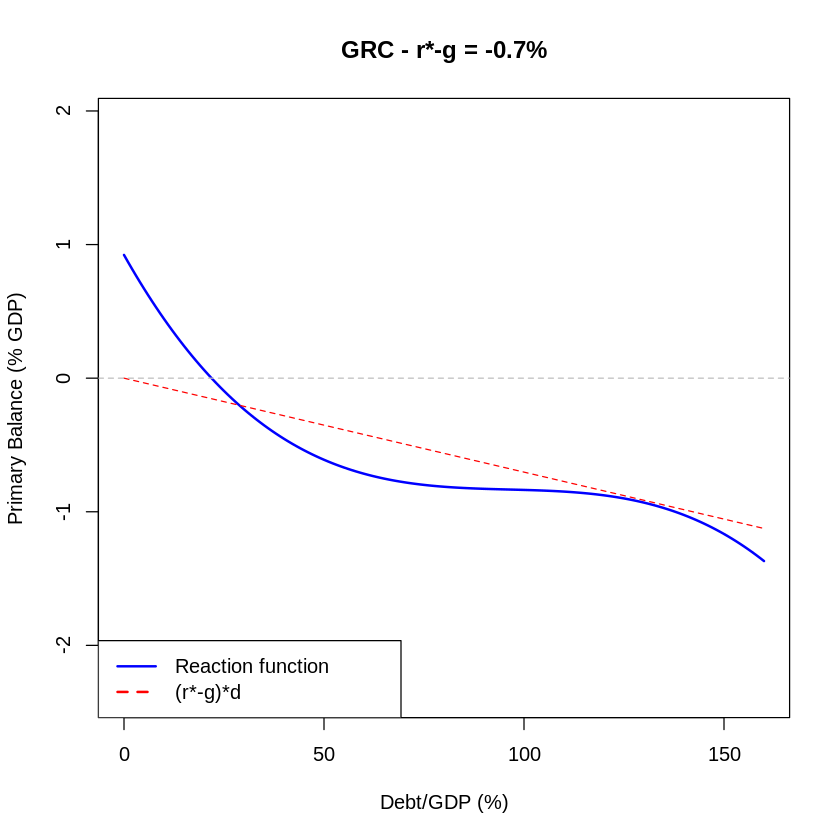

ITA , max crossing and potential deterministic debt limit d_bar: 206

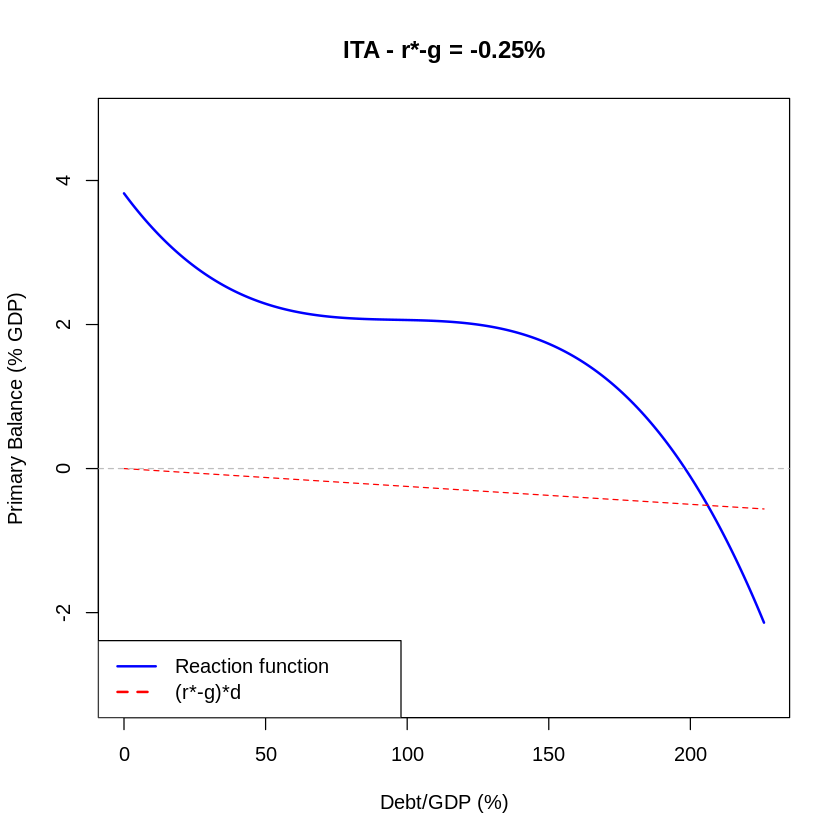

In [97]:
## these plots combined to the crossings allow us to check graphically what deterministic debt limit each country has (or not) and what d* eahc country has
# simple plot: reaction function vs (r*-g)*d line
plot_simple_reaction <- function(country_code, model, fixed_effects, rg_diff, fiscal_data, debt_to_gdp_range=250) {

  # get coefficients
  b1 <- coef(model)["lagged_debt"]
  b2 <- coef(model)["lagged_debt_sq"]
  b3 <- coef(model)["lagged_debt_cubic"]

  # get country fixed effect
  mu <- fixed_effects[country_code]

  # convert r-g to decimal
  rg_decimal <- rg_diff / 100

  # create debt range
  debt_range <- seq(0, debt_to_gdp_range, by = 1)

  # calculate reaction function
  pb_reaction <- mu + b1*debt_range + b2*debt_range^2 + b3*debt_range^3

  # calculate interest line
  interest_line <- rg_decimal * debt_range

  #plot
  plot(debt_range, pb_reaction,
       type = "l", lwd = 2, col = "blue",
       xlab = "Debt/GDP (%)",
       ylab = "Primary Balance (% GDP)",
       main = paste0(country_code, " - r*-g = ", round(rg_diff, 2), "%"),
       ylim = c(min(c(pb_reaction, interest_line)) - 1,
                max(c(pb_reaction, interest_line)) + 1))

  # add interest line
  lines(debt_range, interest_line, lwd = 1, col = "red", lty = 2)

  # add zero line
  abline(h = 0, lty = 2, col = "gray")

  # legend
  legend("bottomleft",
         legend = c("Reaction function", "(r*-g)*d"),
         col = c("blue", "red"),
         lty = c(1, 2),
         lwd = c(2, 2))
}

# plot all countries
par(mfrow = c(1, 1))

for(i in 1:nrow(rg_summary)) {
  country_code <- rg_summary$country[i]
  rg_diff <- rg_summary$rg_diff_10y[i]
  crossings<- find_crossings_simple(country_code, model_ar2, fixed_fx, rg_diff)
  debt_range_max <- max(max(crossings)+20, 160)
  plot_simple_reaction(country_code, model_ar2, fixed_fx, rg_diff, fiscal_data, debt_range_max)
  cat(country_code, ", max crossing and potential deterministic debt limit d_bar:", max(crossings))

}


In [98]:
###model with lag

In [99]:
# find d_bar with model with lag (dynamic)
find_debt_limit_dynamic <- function(country_code, model, fixed_effects, rg_diff, max_debt = 500) {

  # coefficients
  b1 <- coef(model)["lagged_debt"]
  b3 <- coef(model)["lagged_debt_cubic"]
  b5 <- coef(model)["lag(primary_balance, 1)"]  # persistence coef
  mu <- fixed_effects[country_code]

  # r-g en decimal
  rg_decimal <- rg_diff / 100

  # debt range
  debt <- seq(0, max_debt, by = 0.5)

  # steady-state reaction function: pb* = f(d) / (1 - b5)
  # assume output_gap = 0 in long run
  pb_steady <- (mu + b1*debt + b3*debt^3) / (1 - b5)

  # interest line
  interest <- rg_decimal * debt

  # difference
  diff <- pb_steady - interest

  # detect sign changes by multiplying consecutive elements (negative product = crossing)
  sign_change <- which(diff[-1] * diff[-length(diff)] < 0)

  crossings <- debt[sign_change]

  return(crossings)
}


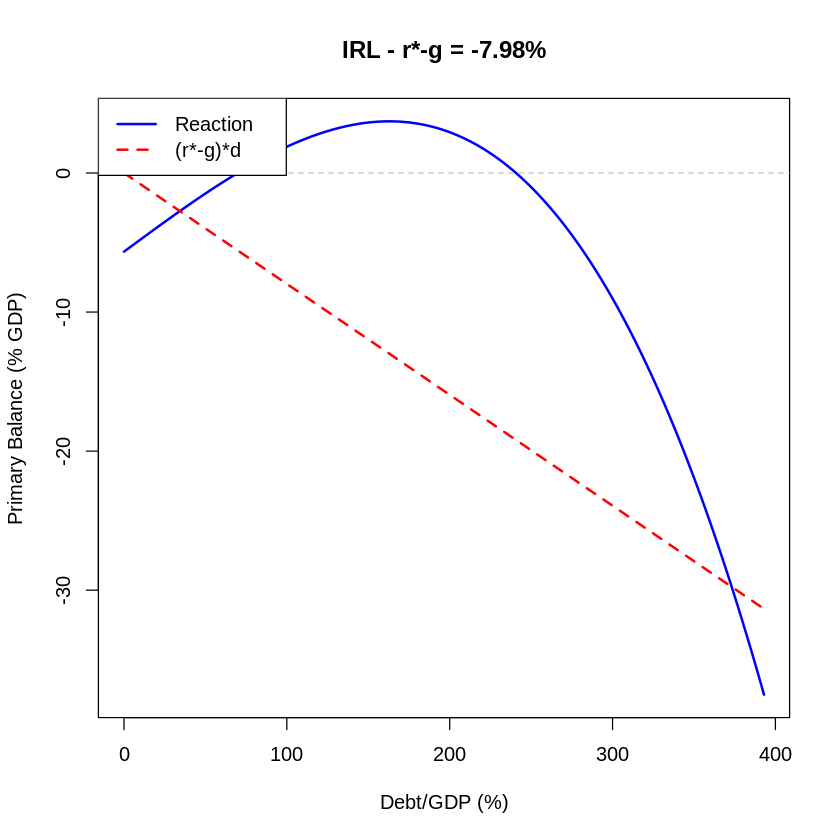

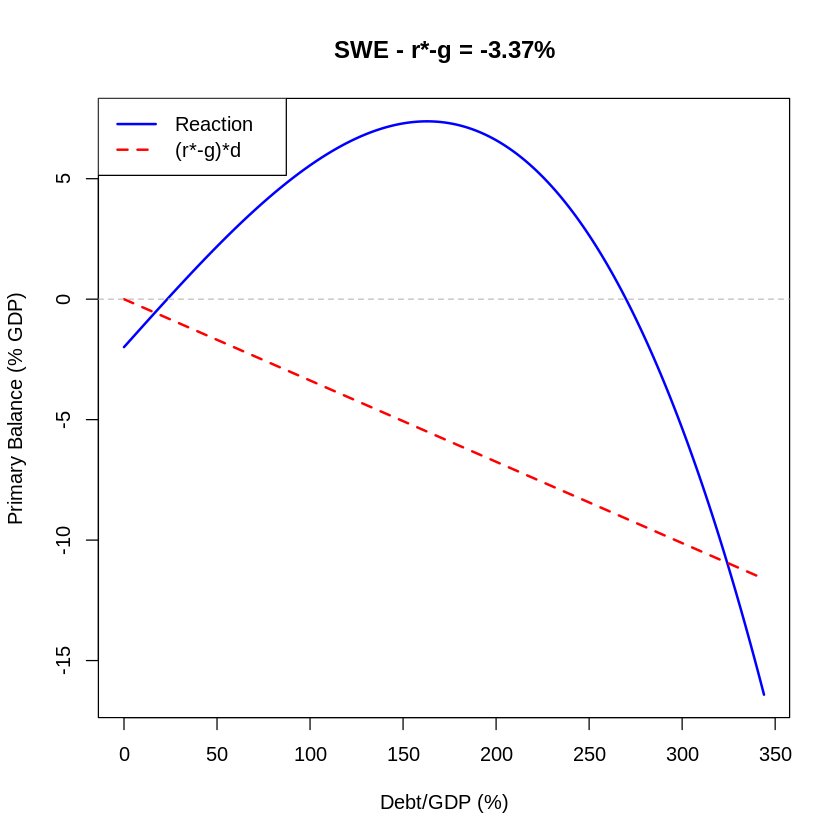

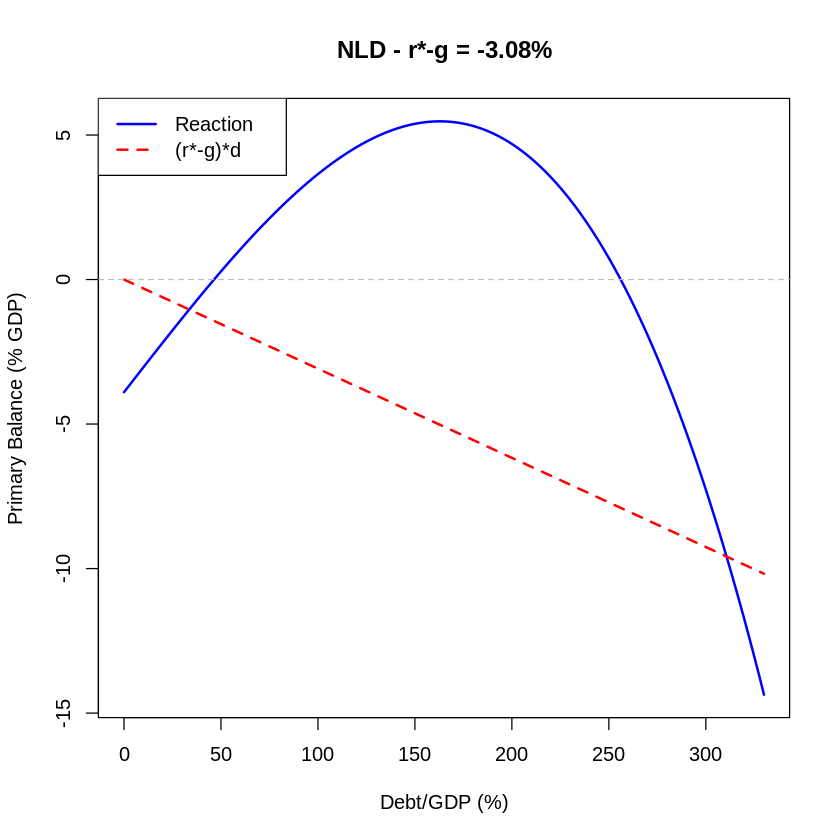

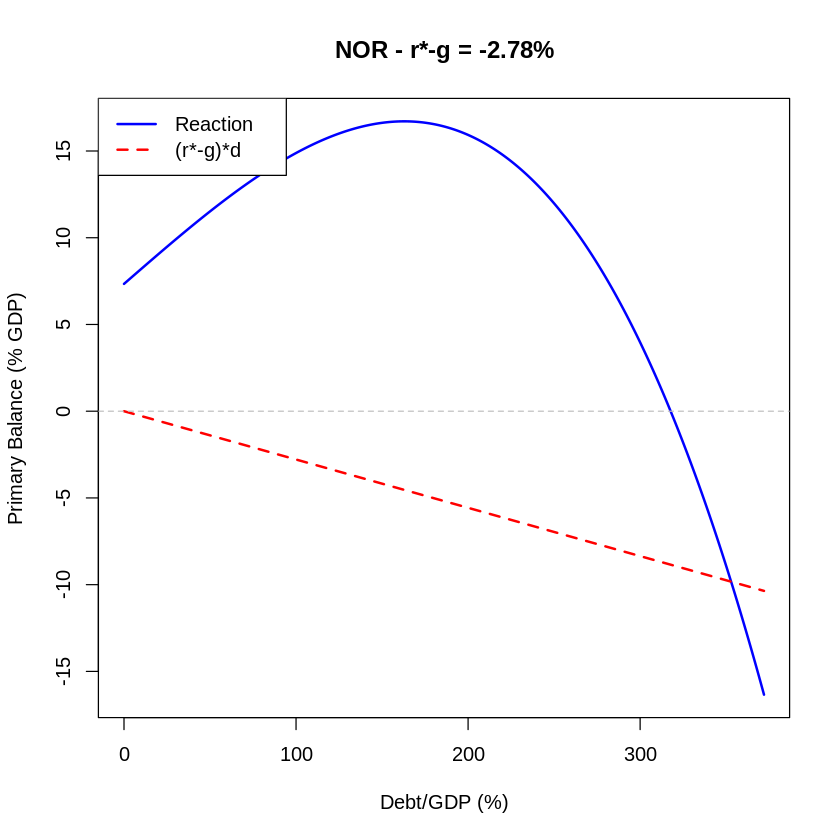

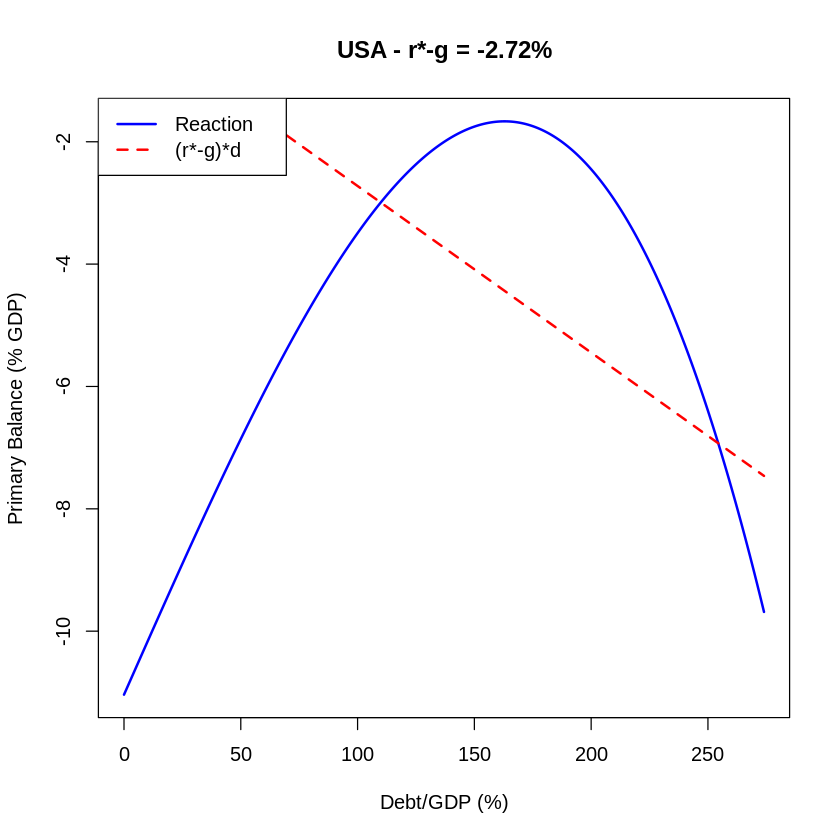

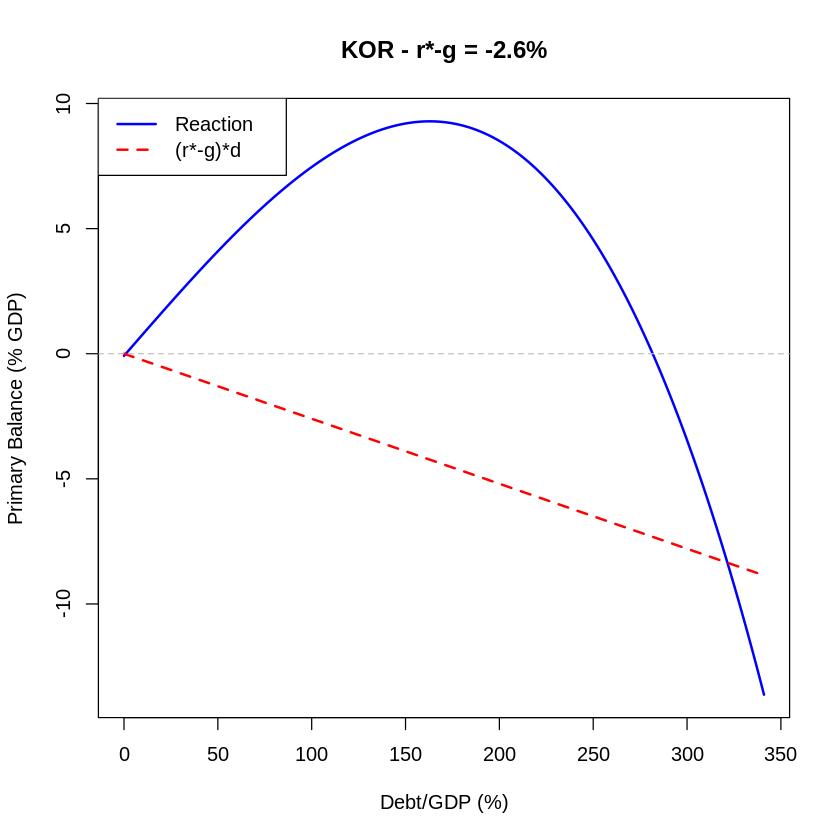

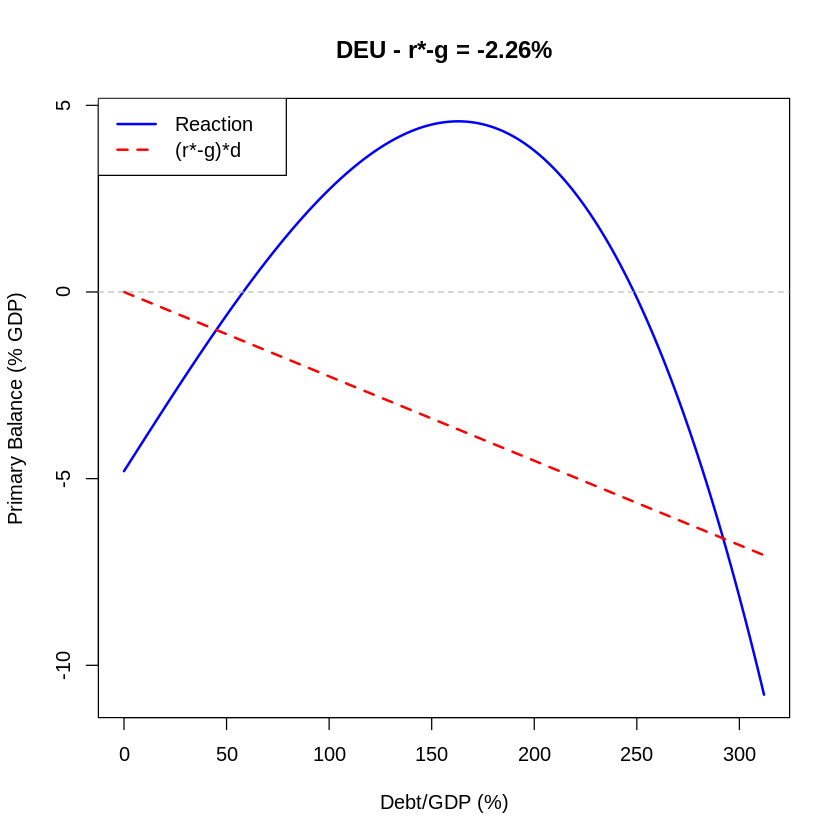

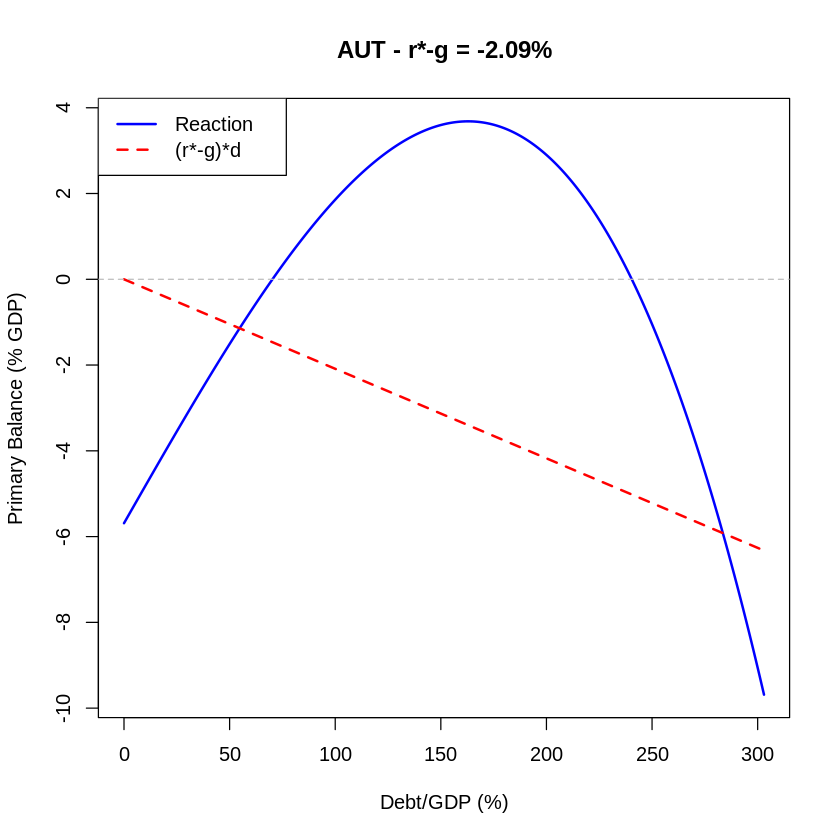

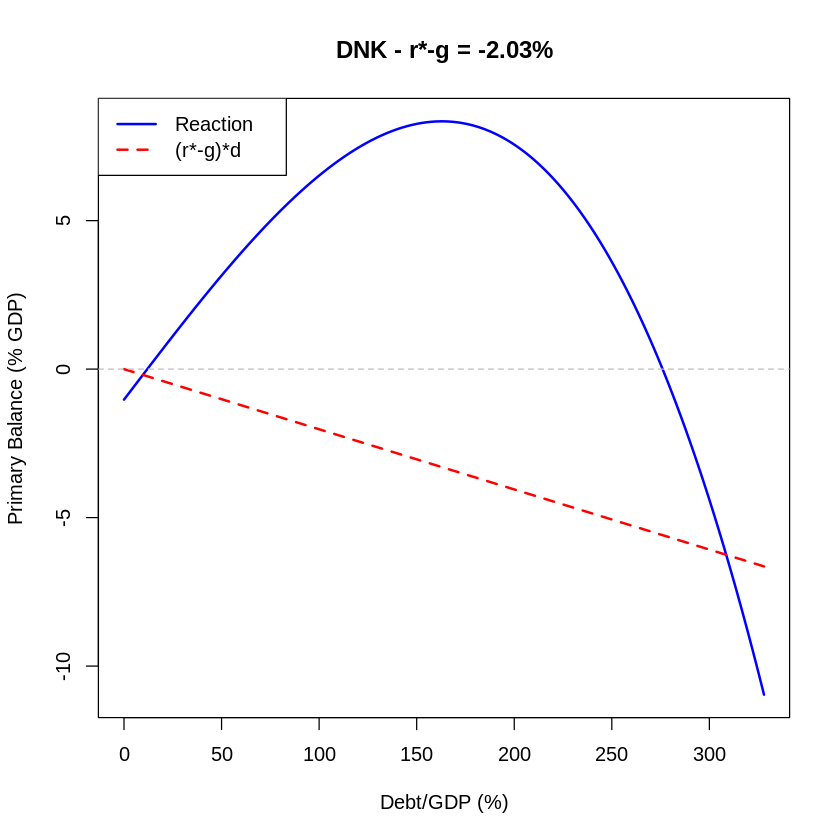

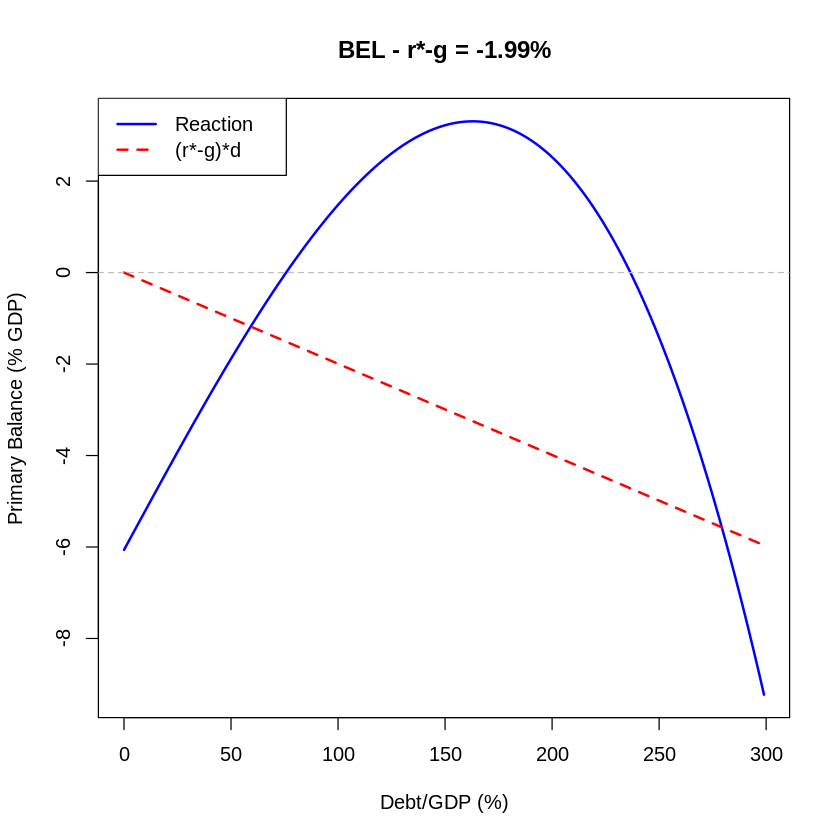

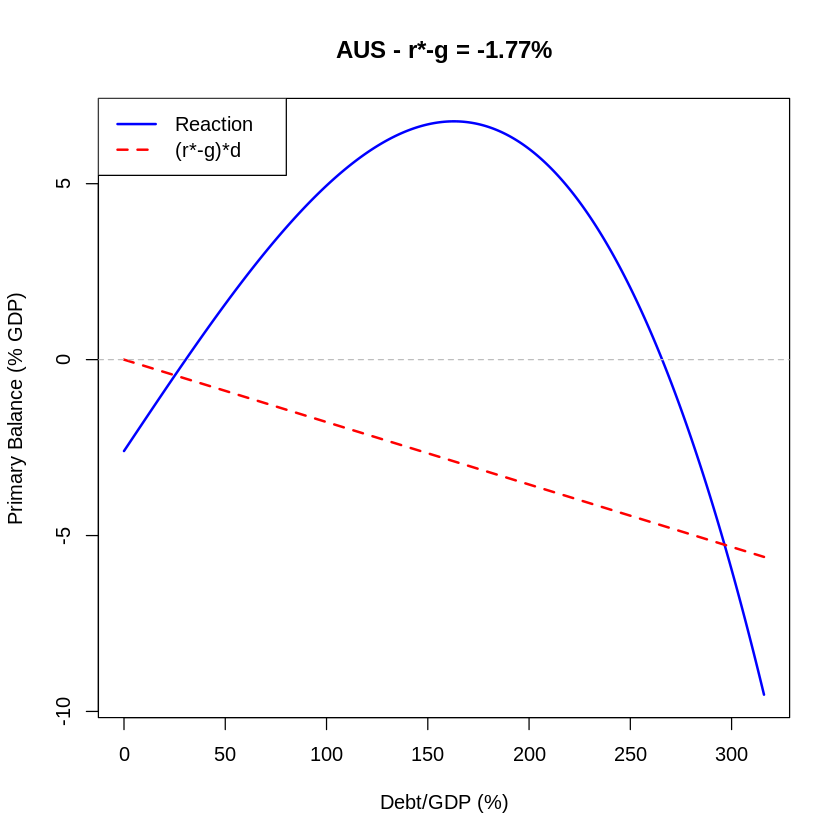

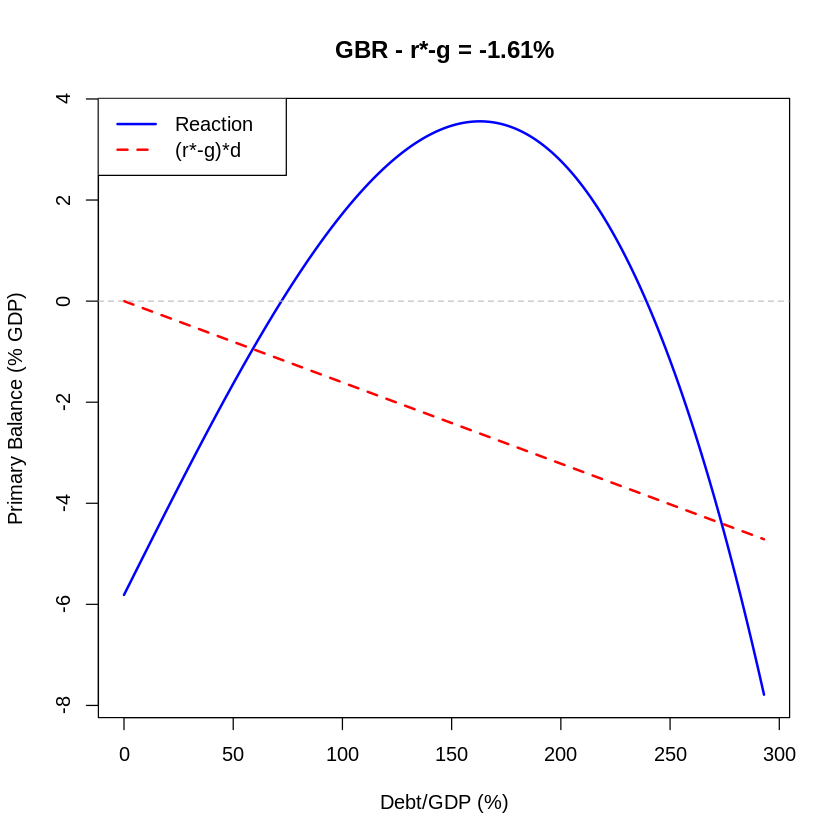

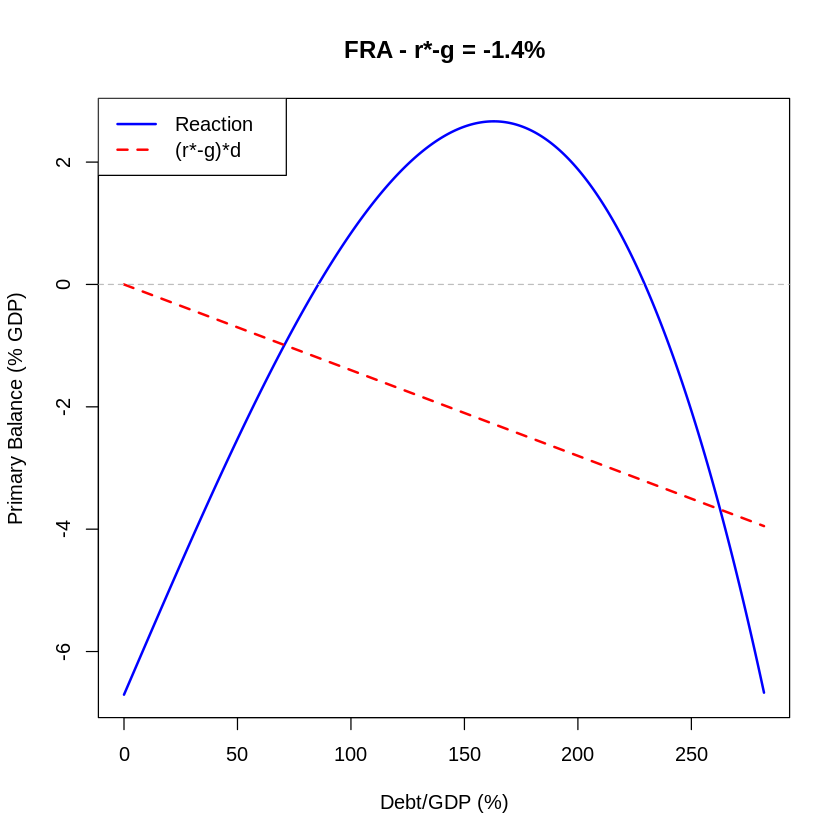

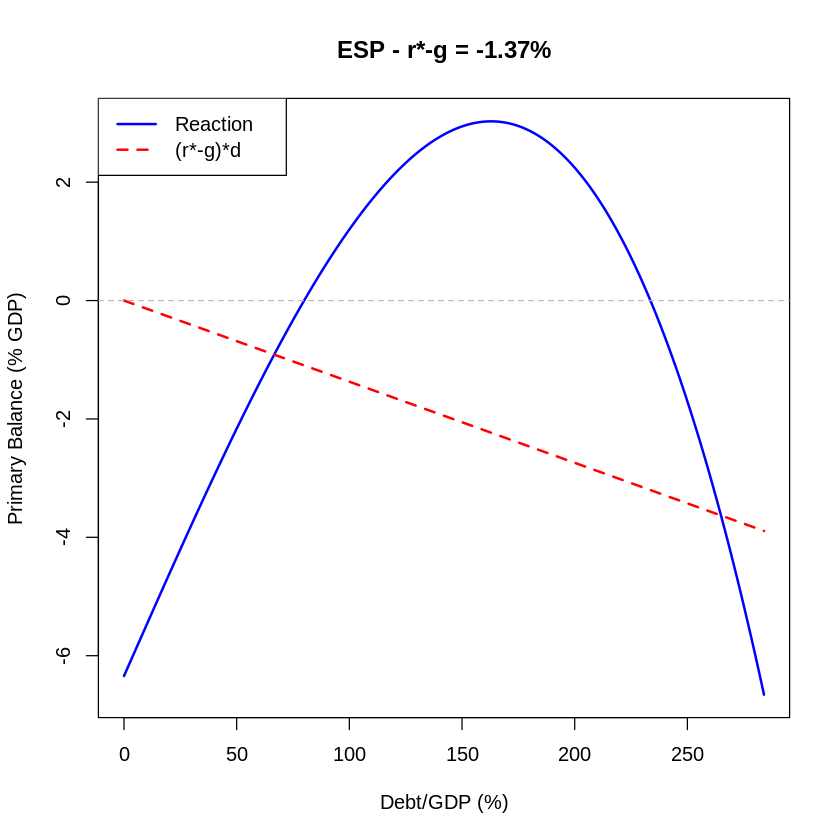

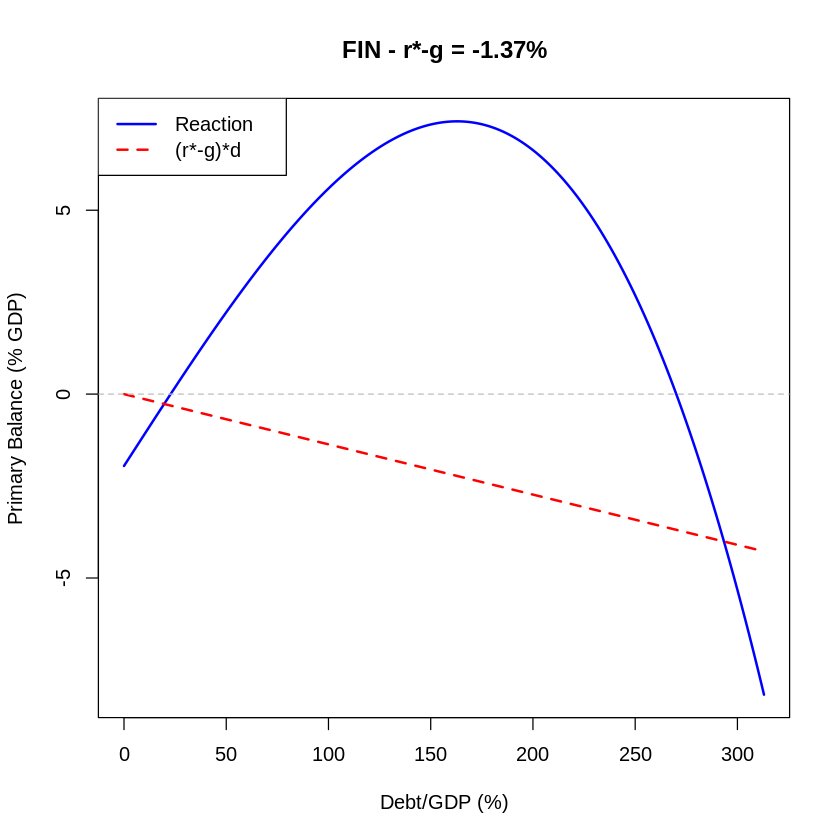

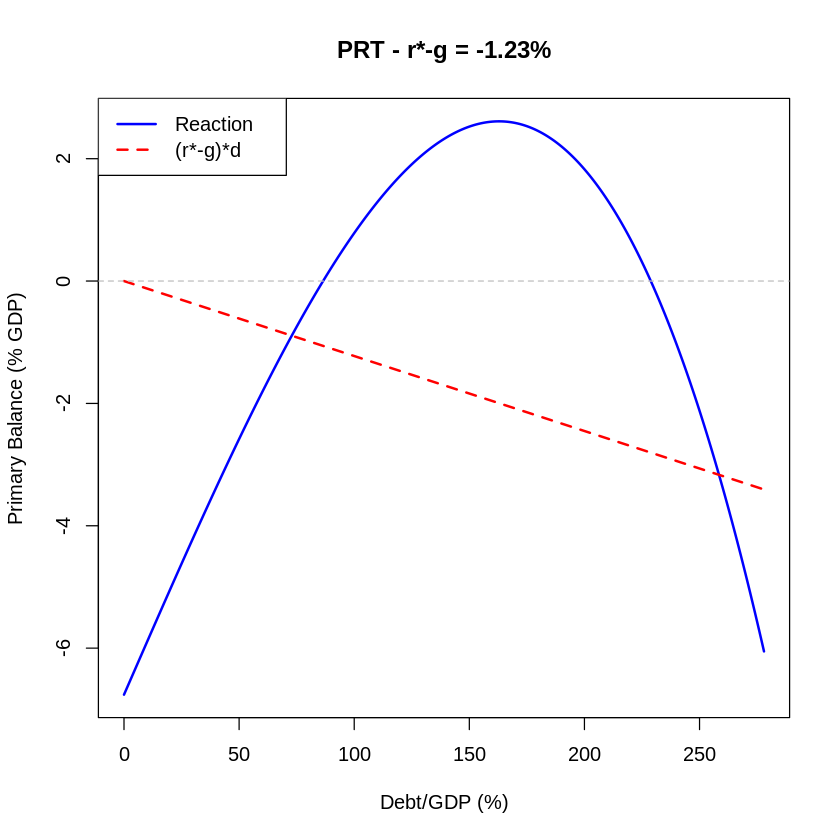

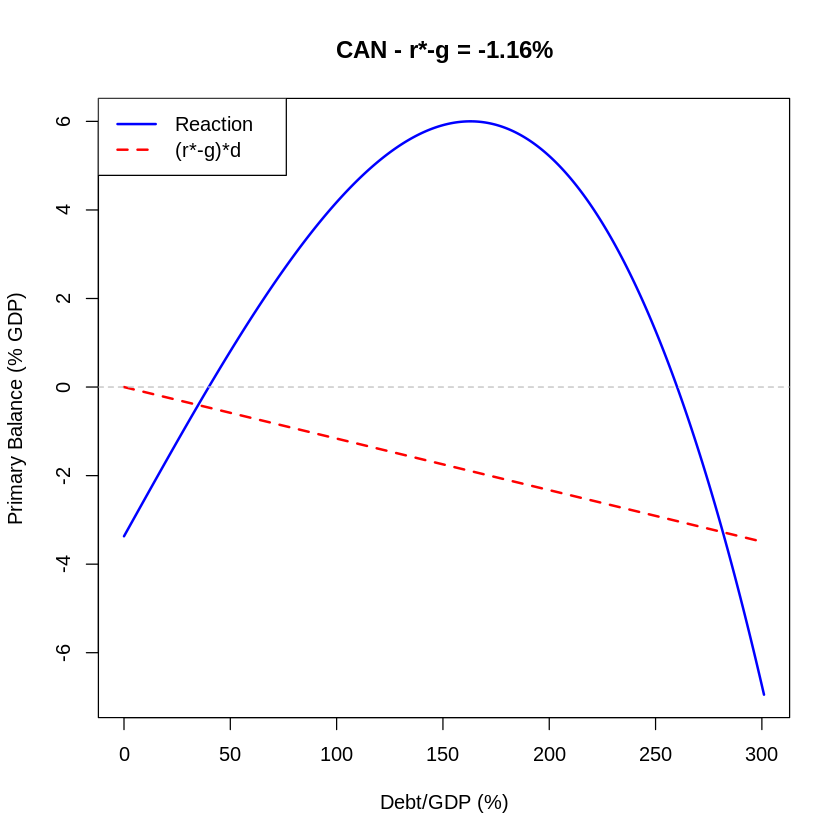

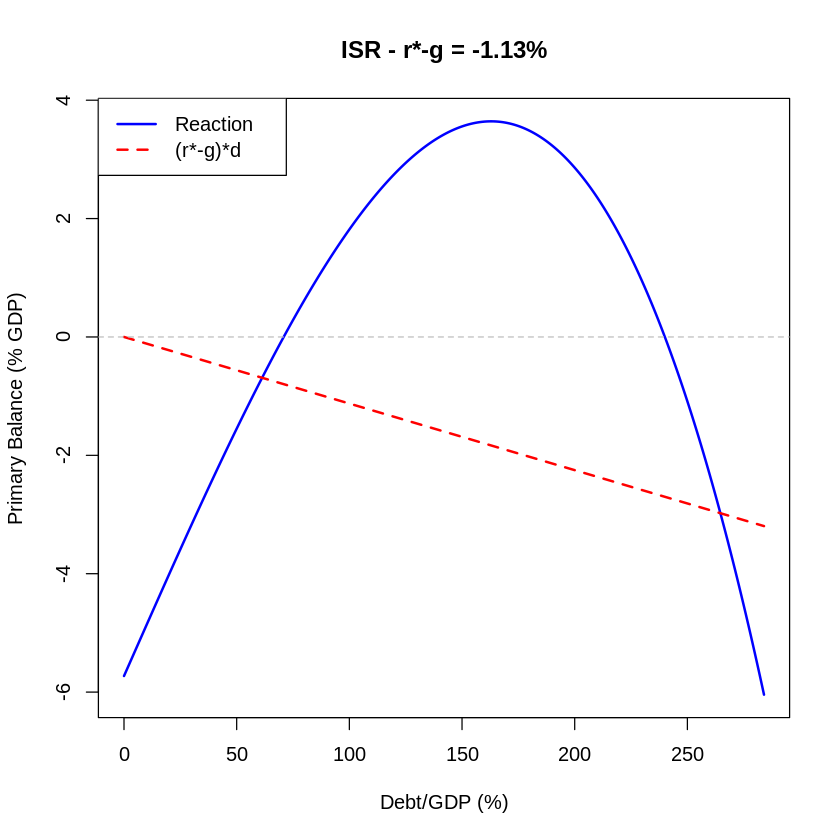

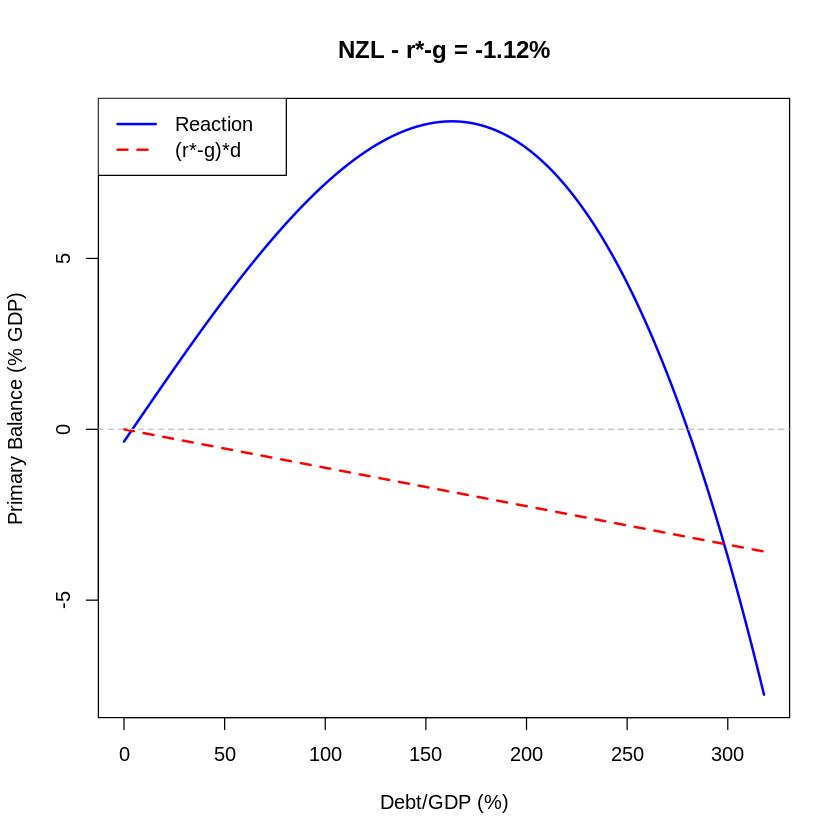

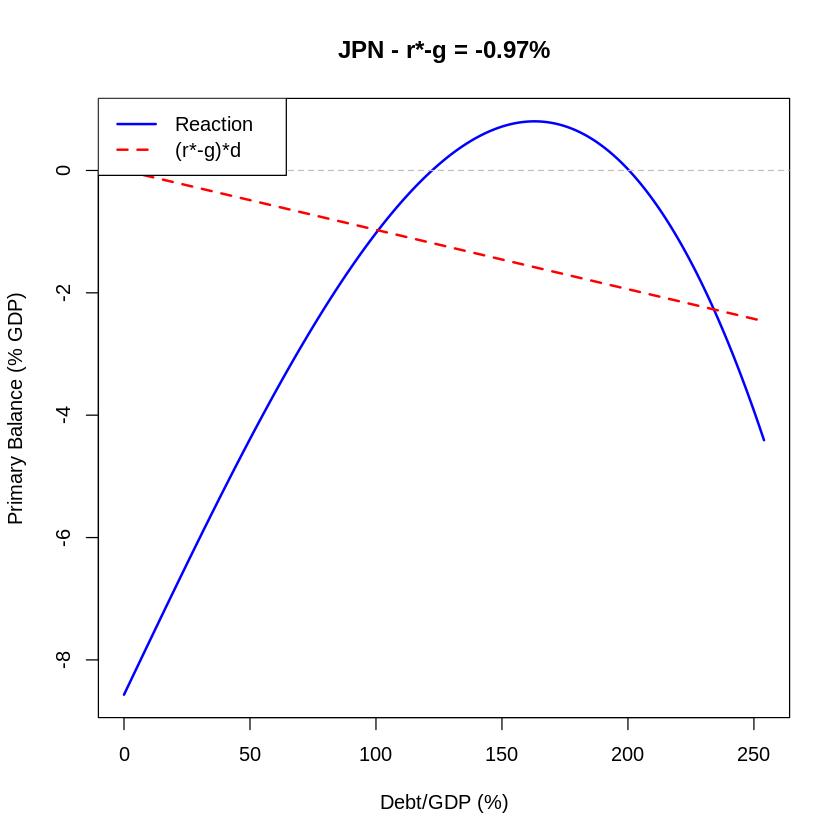

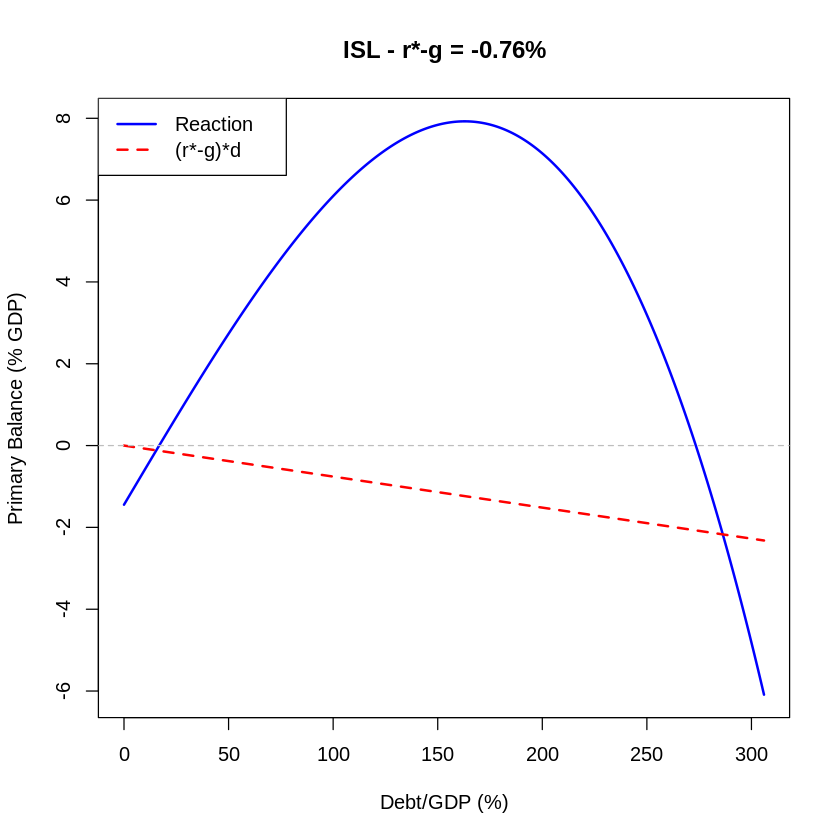

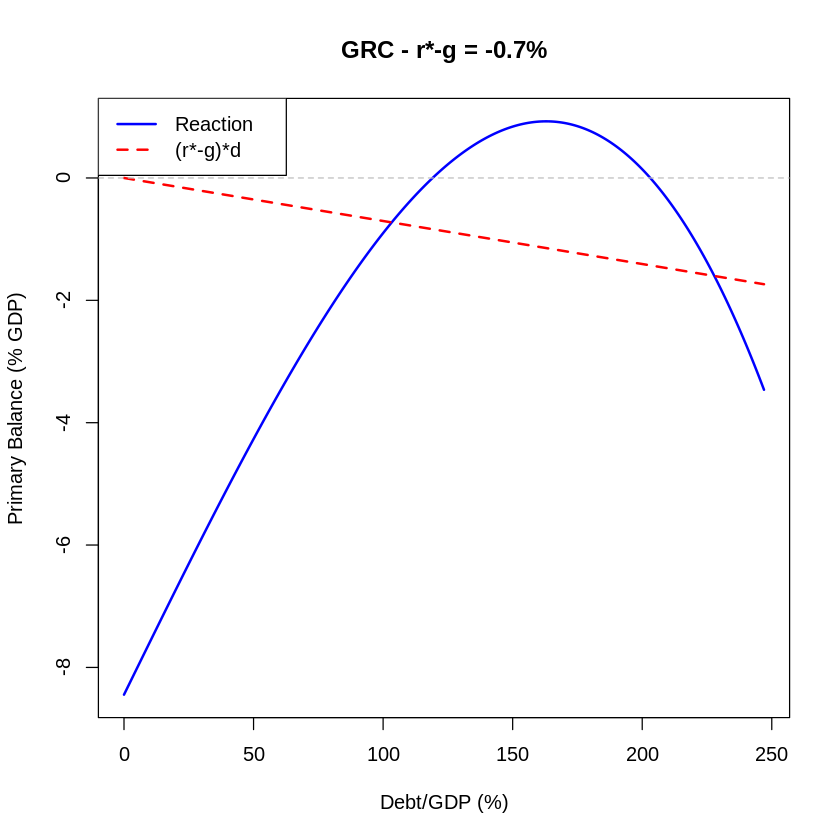

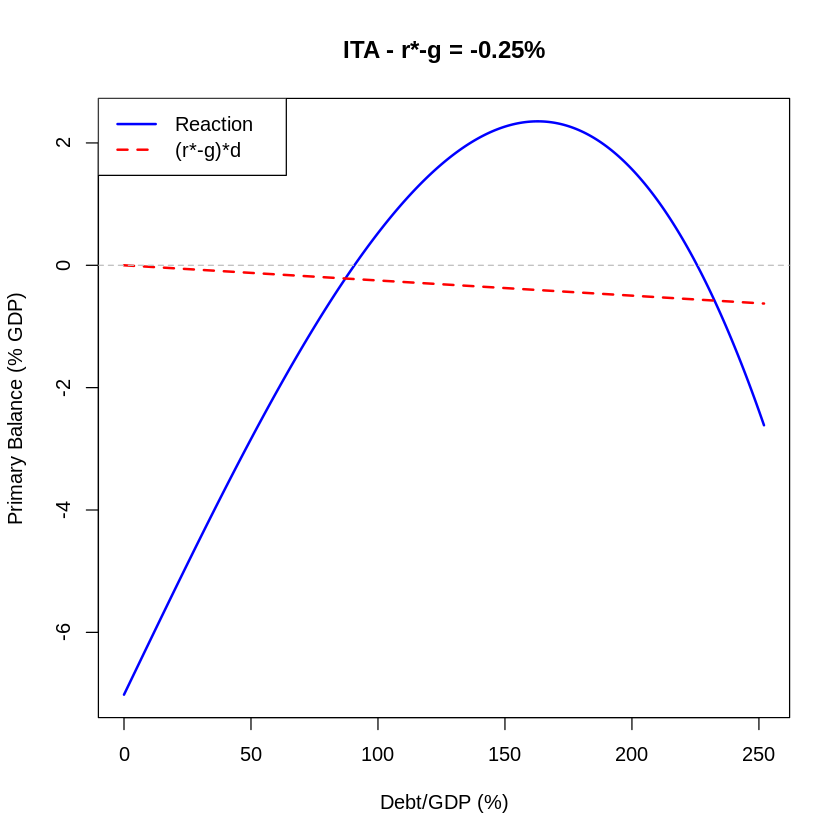

In [101]:
# with models with lag
plot_w_lag <- function(country_code, model, fixed_effects, rg_diff, max_debt = 450) {

  # coefficients
  b1 <- coef(model)["lagged_debt"]
  b3 <- coef(model)["lagged_debt_cubic"]
  b5 <- coef(model)["lag(primary_balance, 1)"]
  mu <- fixed_effects[country_code]

  # r-g en decimal
  rg_decimal <- rg_diff / 100

  # debt range
  debt <- seq(0, max_debt, by = 1)

  # steady-state reaction
  reaction <- (mu + b1*debt  + b3*debt^3) / (1 - b5)

  # interest line
  interest <- rg_decimal * debt

  # plot
  plot(debt, reaction,
       type = "l", lwd = 2, col = "blue",
       xlab = "Debt/GDP (%)",
       ylab = "Primary Balance (% GDP)",
       main = paste0(country_code, " - r*-g = ", round(rg_diff, 2), "%"))

  lines(debt, interest, lwd = 2, col = "red", lty = 2)
  abline(h = 0, lty = 2, col = "gray")

  legend("topleft", legend = c("Reaction", "(r*-g)*d"),
         col = c("blue", "red"), lty = c(1, 2), lwd = 2)
}


fixed_fx_lag2 <- fixef(model_ar2_lag2)

# plot all
par(mfrow = c(1, 1))

for(i in 1:nrow(rg_summary)) {

  crossings <- find_debt_limit_dynamic(rg_summary$country[i], model_ar2_lag2, fixed_fx_lag2,
                    rg_summary$rg_diff_10y[i])
  debt_max = debt_range_max <- max(max(crossings)+20, 160)
  cat
  plot_w_lag(rg_summary$country[i], model_ar2_lag2, fixed_fx_lag2,
                    rg_summary$rg_diff_10y[i],debt_max)
}